# Установка библиотек

In [1]:
pip install phik

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\work_and_fun\partisans\PP\mistakes-and-regrets\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
# https://pypi.org/project/pgeocode/
# pip install pgeocode

In [3]:
pip install geopandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\work_and_fun\partisans\PP\mistakes-and-regrets\Scripts\python.exe -m pip install --upgrade pip' command.


In [4]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\work_and_fun\partisans\PP\mistakes-and-regrets\Scripts\python.exe -m pip install --upgrade pip' command.


In [5]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\work_and_fun\partisans\PP\mistakes-and-regrets\Scripts\python.exe -m pip install --upgrade pip' command.


In [6]:
pip list

Package                  Version
------------------------ -----------
alembic                  1.11.1
anyio                    3.7.0
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
arrow                    1.2.3
asttokens                2.2.1
attrs                    23.1.0
backcall                 0.2.0
beautifulsoup4           4.12.2
bleach                   6.0.0
blinker                  1.6.2
branca                   0.6.0
catboost                 1.2
category-encoders        2.6.1
certifi                  2023.5.7
cffi                     1.15.1
charset-normalizer       3.1.0
click                    8.1.3
click-plugins            1.1.1
cligj                    0.7.2
cloudpickle              2.2.1
cmaes                    0.9.1
colorama                 0.4.6
colorlog                 6.7.0
comm                     0.1.3
contourpy                1.0.7
cycler                   0.11.0
debugpy                  1.6.7
decorator                5.1.1
defusedxml             

You should consider upgrading via the 'C:\work_and_fun\partisans\PP\mistakes-and-regrets\Scripts\python.exe -m pip install --upgrade pip' command.


# Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, чтобы привлечь новых клиентов. В нём можно будет узнать рыночную стоимость своего автомобиля. Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей. Критерии, которые важны заказчику:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
Проанализируйте время обучения, время предсказания и качество моделей.
Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.
Примечания:
Для оценки качества моделей применяйте метрику RMSE.
Значение метрики RMSE должно быть меньше 2500.
Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.

Описание данных
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
Целевой признак
* Price — цена (евро)

# Импорт библиотек

In [7]:
# PyCharm lt+ctrl+o

import re
import time
import warnings

import catboost as cb
import geopandas as gpd
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import pgeocode as geo
import phik
import seaborn as sns
import xgboost as xgb
from optuna.integration import CatBoostPruningCallback
from scipy import sparse
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler

rs = 123

In [8]:
try:
    df = pd.read_csv('autos.csv')
    df = pd.read_csv('autos_with_geo.csv')

except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [9]:
try:
    top_cities = pd.read_csv('top_cities.csv')
except:
    top_cities = pd.read_csv('https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000/exports/csv?lang=en&timezone=Europe%2FMinsk&use_labels=true&delimiter=%3B', sep=';')

Сразу удалим дубликаты

In [10]:
print(f'Было {df.duplicated().sum()} полных дубликатов')
df = df.drop_duplicates()
print(f'Осталось {df.duplicated().sum()} полных дубликатов')

Было 4 полных дубликатов
Осталось 0 полных дубликатов


Взглянем на данные

In [11]:
df.sample(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,PlaceName,StateName,Latitude,Longitude
340418,2016-03-22 13:48:48,3100,bus,2003,manual,150,espace,150000,8,gasoline,renault,no,2016-03-22 00:00:00,0,57413,2016-04-06 02:45:28,Finnentrop,Nordrhein-Westfalen,51.1680,7.9730
315012,2016-03-31 17:46:02,2399,wagon,2001,manual,143,c_klasse,150000,12,gasoline,mercedes_benz,yes,2016-03-31 00:00:00,0,44339,2016-04-02 13:16:22,Dortmund,Nordrhein-Westfalen,51.5607,7.4657
340828,2016-03-17 20:52:41,4200,coupe,1998,manual,136,clk,150000,8,petrol,mercedes_benz,no,2016-03-17 00:00:00,0,71272,2016-04-07 11:16:34,Renningen,Baden-Württemberg,48.7697,8.9387


Переименуем названия колонок

In [12]:
df.columns = ['_'.join(words).lower() for words in [re.findall(r'([A-Z]{1}[a-z]+)', el) for el in df.columns]]

Напишем функцию, выводящую всю статистическую информацию по датасету

In [13]:
def full_info(df):
    display(pd.DataFrame({'Non-Null Count': (~df.isna()).sum(),
                          'Null Count': df.isna().sum(),
                          'Dtype': df.dtypes}).join(df.describe().T).rename_axis('Feature', axis=1).fillna(''))

In [14]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
date_crawled,354365,0,object,,,,,,,,
price,354365,0,int64,354365.0,4416.67983,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
vehicle_type,316875,37490,object,,,,,,,,
registration_year,354365,0,int64,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
gearbox,334532,19833,object,,,,,,,,
power,354365,0,int64,354365.0,110.093816,189.85133,0.0,69.0,105.0,143.0,20000.0
model,334660,19705,object,,,,,,,,
kilometer,354365,0,int64,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,354365,0,int64,354365.0,5.71465,3.726432,0.0,3.0,6.0,9.0,12.0
fuel_type,321470,32895,object,,,,,,,,


Наблюдения следующие
- В пяти колонках есть пропуски
- в колонке number_of_pictures одни нули
- Типы данных неоптимальны

# EDA + Feature Generation

По порядку пройдем по всем признакам

## price

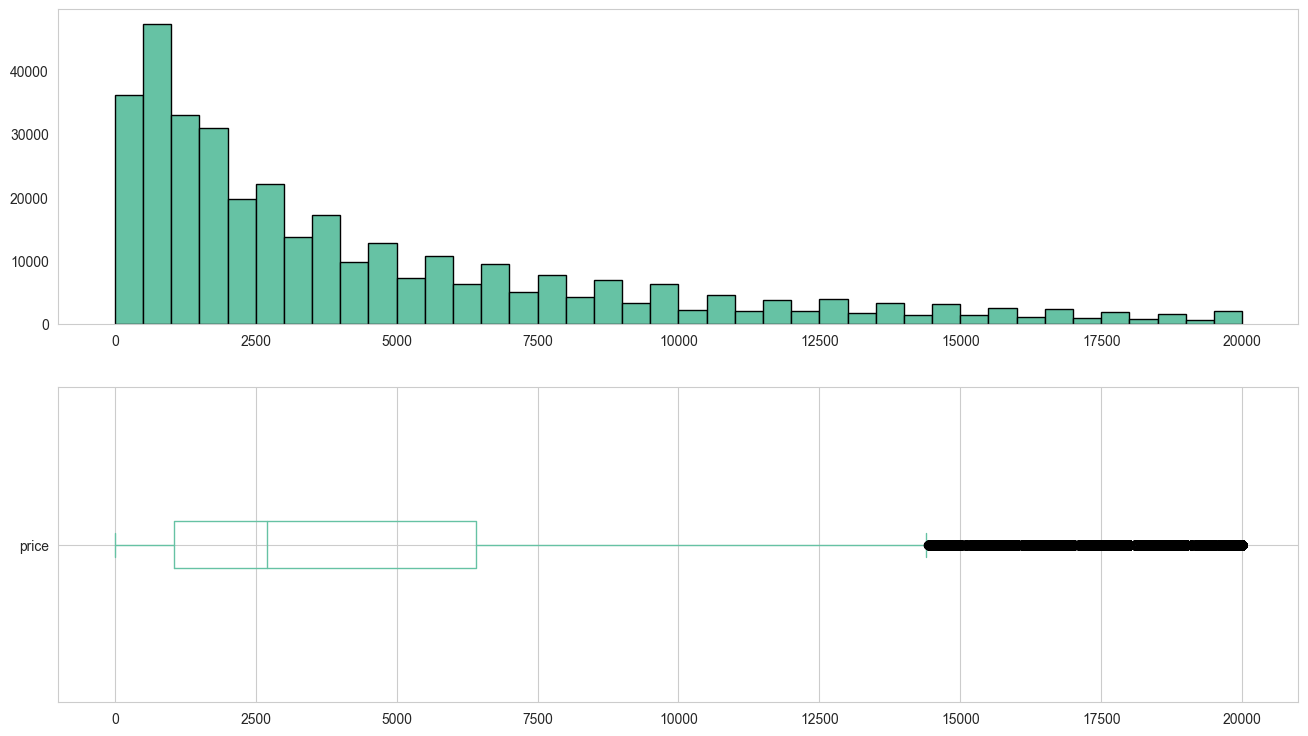

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 9))
df['price'].hist(grid=False, bins=40, color='#66c2a4', ec='k', ax=ax1);
df['price'].plot.box(grid=True, vert=False, color='#66c2a4', ax=ax2);

Для цен характерно распределение Пуассона, оставим только объявления дороже 300 евро. А 20 тыс - нормальная цена для хорошего авто

In [16]:
df = df[df['price']>300]

## number_of_pictures

In [17]:
try:
    print(f'в датасете {df["number_of_pictures"].unique()[0]} уникальных значений в поле с числом фотографий')
    df = df.drop('number_of_pictures', axis=1)
except:
    print('Столбец уже удален')

в датасете 0 уникальных значений в поле с числом фотографий


Фотографий нет ни у кого

## postal_code

У нас есть колонка с почтовым индексом. Возможно, по ней удастся установить географию объявлений. При помощи библиотеки pgeocode добавим в датасет название населенного пункта и области, а также долготу и широту/
В следующий раз для зипкодов нужно попробовать [вот это](https://woodwork.alteryx.com/en/v0.7.1/generated/woodwork.logical_types.PostalCode.html). Это что-то более поддерживаемое

In [18]:
nomi = geo.Nominatim('DE')
def postal_coder(row):
    res = nomi.query_postal_code(row)
    return res['place_name'], res['state_name'], res['latitude'], res['longitude']

In [19]:
%%time
df['postal_code'].head(10).apply(postal_coder)

CPU times: total: 46.9 ms
Wall time: 48 ms


0     (Stuttgart, Stuttgart Zuffenhausen, Baden-Würt...
1         (Pirmasens, Rheinland-Pfalz, 49.2071, 7.5911)
2                  (Nürnberg, Bayern, 49.4371, 11.1194)
3             (Herzogenaurach, Bayern, 49.568, 10.8856)
4          (Frankfurt am Main, Hessen, 50.1924, 8.6753)
5      (Versmold, Nordrhein-Westfalen, 52.0401, 8.1527)
6       (Mutterstadt, Rheinland-Pfalz, 49.4414, 8.3561)
8                  (Bernried, Bayern, 48.9167, 12.8833)
9             (Cuxhaven, Niedersachsen, 53.8584, 8.709)
10              (Burgkunstadt, Bayern, 50.1409, 11.252)
Name: postal_code, dtype: object

Функция работает довольно долго, поэтому мы воспроизвели датасет из сохраненного заранее файла

In [20]:
# %%time
# df['PlaceName'], df['StateName'], df['Latitude'], df['Longitude'], = zip(*df['PostalCode'].apply(postal_coder))

In [21]:
print(f'Геоданные не найдены для {df["place_name"].isna().sum()} записей')

Геоданные не найдены для 15984 записей


Пока не убедимся, что признаки полезны, не будем удалять эти записи

In [22]:
# %%time
# top_cities = pd.read_csv('https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000/exports/csv?lang=en&timezone=Europe%2FMinsk&use_labels=true&delimiter=%3B', sep=';')

top_cities = top_cities[top_cities['LABEL EN']=='Germany'].sort_values('Population', ascending=False)[['Name', 'Coordinates', 'Population']]

top_cities['latitude'] = top_cities['Coordinates'].apply(lambda x: x.split(',')[0])
top_cities['longitude'] = top_cities['Coordinates'].apply(lambda x: x.split(',')[1])
top_cities.drop('Coordinates', axis=1, inplace=True)

top_cities['longitude'] = top_cities['longitude'].astype('float')
top_cities['latitude'] = top_cities['latitude'].astype('float')

# Два города накладываются друг на друга
top_cities = top_cities[top_cities['Name']!='Großzschocher']

Посмотрим, сколько городов дублируется

In [23]:
print(f'{top_cities.shape[0]-top_cities["Name"].nunique()} городов повторяется. Надо удалить')

352 городов повторяется. Надо удалить


In [24]:
top_cities = top_cities.drop_duplicates('Name')

In [25]:
top_cities

,Name,Population,latitude,longitude
10924,Berlin,3426354,52.52437,13.41053
114885,Hamburg,1845229,53.55073,9.99302
124321,Munich,1260391,48.13743,11.57549
11720,Köln,963395,50.93333,6.95000
18203,Frankfurt am Main,650000,50.11552,8.68417
...,...,...,...,...
27463,Falkenfels,1001,49.00415,12.59480
78533,Pfeffelbach,1001,49.53948,7.32768
93507,Burg Unter-Falkenstein,0,47.70440,12.10466
61814,Haselbachtal,0,51.23570,14.02576


In [26]:
tmp = df.groupby('postal_code').agg(longitude=('longitude', 'first'),
                                         latitude=('latitude', 'first'),
                                         count=('place_name', 'count'),
                                         median=('price', 'median')).query('count>20')
tmp

,longitude,latitude,count,median
postal_code,,,,
10115,13.384600,52.532300,809,10500.0
10117,13.387200,52.517000,64,4625.0
10119,13.405300,52.530500,47,2850.0
10178,13.409600,52.521300,52,4000.0
10179,13.416400,52.512200,41,3500.0
...,...,...,...,...
99894,10.591633,50.852300,32,3515.0
99897,10.615700,50.792500,21,2000.0
99947,10.638018,51.157027,65,3000.0


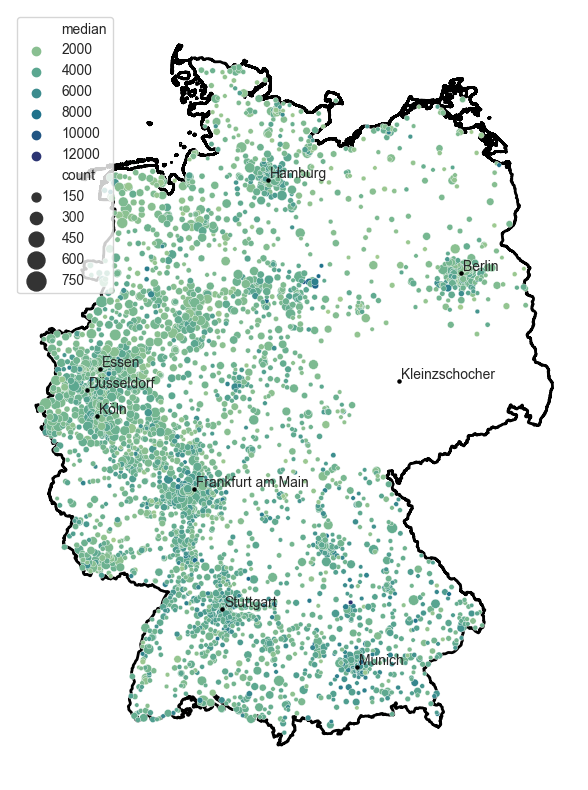

In [27]:
germany = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/1_deutschland/1_sehr_hoch.geo.json')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
germany.plot(ax=ax, color='white', edgecolor='k', linewidth=2)

sns.scatterplot(data=tmp,
                y='latitude',
                x='longitude',
                hue='median',
                palette='crest',
                size='count',
                sizes=(10, 200), ax=ax);

ax.scatter(top_cities['longitude'].head(9), top_cities['latitude'].head(9), c='k', s=5)
for row in top_cities.head(9).iterrows():
    ax.annotate(text=row[1]['Name'],
                xy=(row[1]['longitude'], row[1]['latitude']),
                xytext=(1.5, 1.5),
                textcoords='offset points')

ax.axis('off')
ax.legend(loc='upper left')
ax.grid(False);

По какой-то причине не распознались почтовые индексы на востоке Германии. Яркий пример MNAR

Добавим в таблицу население городов, но прежде проверим, население скольких городов мы не знаем

In [28]:
%%time
# df['place_name'].apply(lambda x: 0 if x in top_cities['Name'].values else 1).sum()

CPU times: total: 0 ns
Wall time: 0 ns


Почти треть. Можно было бы добавить население ближайшего по координатам города, но функция будет слишком долго работать

In [29]:
df = pd.merge(df, top_cities.set_index('Name')['Population'], left_on='place_name', right_index=True, how='left')

In [30]:
df = df.rename({'Population': 'population'}, axis=1)

In [31]:
print(f'Координаты неизвестны для {df["latitude"].isna().sum()/df["latitude"].shape[0]:.1%} записей')
print(f'Население неизвестно для {df["population"].isna().sum()/df["population"].shape[0]:.1%} записей')

Координаты неизвестны для 4.9% записей
Население неизвестно для 27.9% записей


Добавить координаты и плотность населения не удалось для большого числа записей, пропуски нужно чем-то заполнить. Первое, что приходит в голову, это заполнить средним/медианой, но судя по карте, пропуски имеют закономерность - большинство из них расположены на востоке Германии, а заполнение средним наоборот поместит их на запад. Но проект учебный, так что ничего страшного

Названия населенных пунктов и регионов слишком увеличат размерность, так что их стоит удалить

In [32]:
df = df.drop(['place_name', 'state_name'], axis=1)

## date_crawled

In [33]:
df['date_crawled'] = pd.to_datetime(df['date_crawled'])

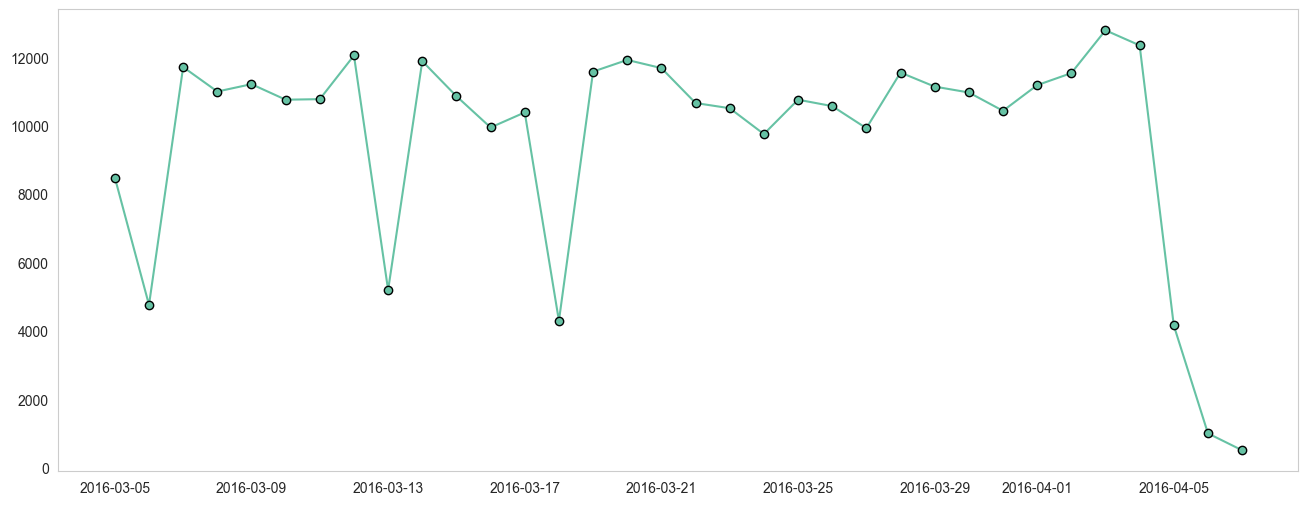

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df['date_crawled'].dt.date.value_counts().plot(grid=False, marker='o', markeredgecolor='k', color='#66c2a4', ax=ax);

## brand

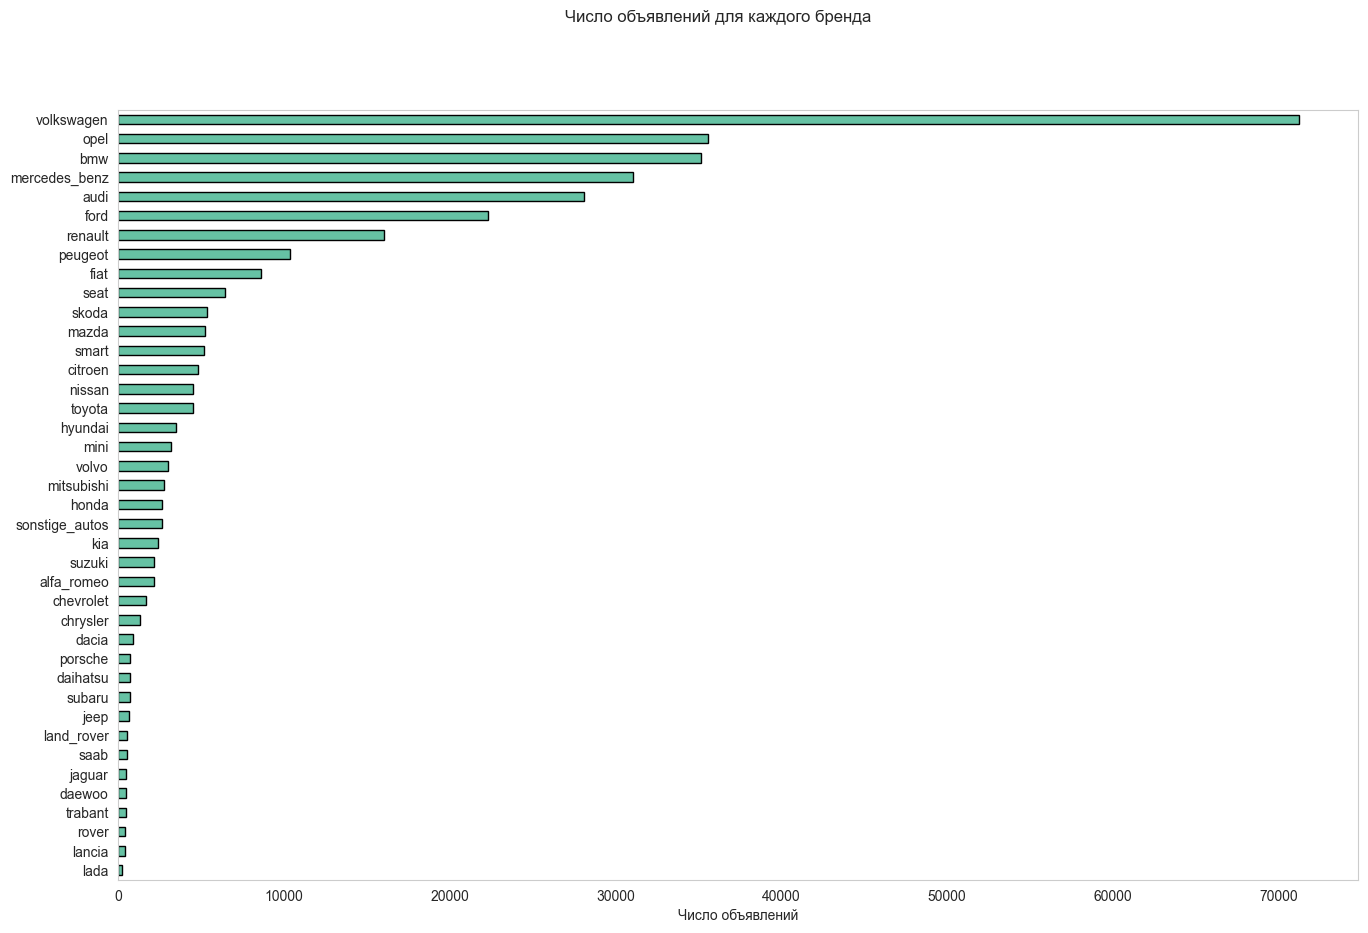

In [35]:
df['brand'].value_counts()[::-1].plot.barh(figsize=(16, 10), color='#66c2a4', ec='k', grid=False);
plt.suptitle('Число объявлений для каждого бренда')
plt.xlabel('Число объявлений');

Много брендов встречаются всего в нескольких сотнях объявлений

## model

У разных брендов модели могут называться одинаково. Проверим это

In [36]:
df.groupby('model')['brand'].nunique().sort_values().tail(10)

model
corsa          1
3_reihe        2
matiz          2
5_reihe        2
1_reihe        2
defender       2
freelander     2
discovery      2
grand          3
other         39
Name: brand, dtype: int64

Надеемся, третий рейх это безобидное обозначение поколения автомобиля

Посмотрим, под какими брендами выпускается Дефендер

In [37]:
df[df['model']=='defender']['brand'].unique()

array(['land_rover', 'rover'], dtype=object)

Кажется, это один бренд, объединим такие записи

In [38]:
df.loc[:, 'brand'] = df['brand'].replace({'rover': 'land_rover'})

Много моделей не опознано. Заменим их на other

In [39]:
df.loc[:, 'model'] = df['model'].fillna('other')

Анализ показал, что у разных брендов модели могут называться одинаково, поэтому добавим в поле с моделью имя бренда

In [40]:
df.loc[:, 'model'] = df.apply(lambda x: ' '.join([x['brand'], x['model']]), axis=1)

In [41]:
df['model'].sample(3)

208661         fiat stilo
137377         seat ibiza
43618     peugeot 2_reihe
Name: model, dtype: object

## vehicle_type

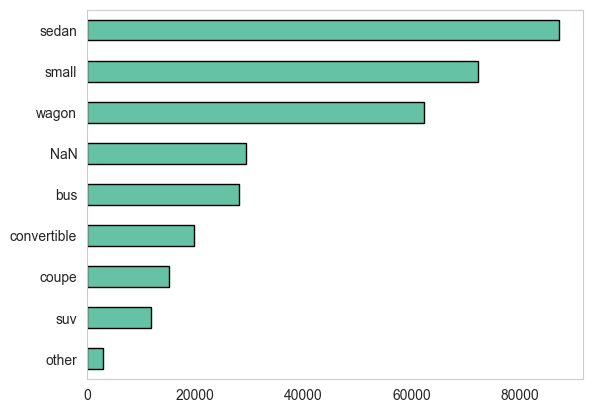

In [42]:
df['vehicle_type'].fillna('NaN').value_counts()[::-1].plot.barh(color='#66c2a4', ec='k', grid=False);

Почти 40000 тысяч пропусков. Проверим, можно ли их заполнить наиболее популярным типом кузова для данной модели

In [43]:
def grouper(data, columns_group, column_res):
    return df.groupby([columns_group, column_res])[column_res].count().to_frame()

In [44]:
grouper(data=df, columns_group='model', column_res='vehicle_type').head(20)

vehicle_type
model            vehicle_type              
alfa_romeo 145   coupe                    2
                 other                    1
                 sedan                   10
                 small                   14
alfa_romeo 147   coupe                   26
                 other                    6
                 sedan                  357
                 small                   93
                 wagon                    2
alfa_romeo 156   coupe                    3
                 other                    1
                 sedan                  244
                 small                    2
                 wagon                  275
alfa_romeo 159   sedan                   55
                 wagon                  143
alfa_romeo other convertible              1
                 coupe                  194
                 other                    5
                 sedan                  202

Видно, что для большинства автомобилей есть выраженный наиболее популярный тип кузова.

Напишем функцию для заполнения нанов на основании наиболее популярного значения в группировке соседнего признака

In [45]:
# Функция реализована очень тупо. Таблицы мерджатся, а потом наны заполняются по новой колонке и она удаляется. Надо использовать transform

def filler(data, columns_group, column_res):

    pivot = data.groupby(columns_group)[column_res].agg(pd.Series.mode).to_frame()
    pivot.columns = ['res' for column in pivot.columns]
    # Далее обработка на случай, если мода - это массив из нескольких значений. Берем последнее значение (это обычно седан)
    for i, row in enumerate(pivot['res']):
        if type(row)==np.ndarray:
            pivot.iloc[i, :] = row[-1]

    data = data.merge(pivot, left_on=columns_group, right_index=True, how='left')
    data[column_res] = data[column_res].fillna(data['res'])
    data = data.drop('res', axis=1)

    return data

In [46]:
print(f'Нанов было {df["vehicle_type"].isna().sum()}')
df = filler(data=df, columns_group='model', column_res='vehicle_type')
print(f'Осталось {df["vehicle_type"].isna().sum()} Нанов')

Нанов было 29295
Осталось 0 Нанов


## registration_year

In [47]:
df['registration_year'].round(-2).value_counts().head(15)

2000     328288
1900         88
1000         22
10000        12
5000          9
6000          5
1800          4
1600          3
7000          3
4500          2
3000          2
5600          2
2500          2
5900          2
4000          2
Name: registration_year, dtype: int64

в 2000-ые или хотя бы в 1900-ые было выпущено большинство машин. Тем не менее, достаточно много машин имеют неадекватный год выпуска. Заменим его на медианный для комбинации марка-модель на кросс-валидации

Убедимся, что наше предположение о невысокой дисперсии года выпуска для сочетания марка-модель верно. Возьмем только машины, выпущенные в адекватные 1920-2019 годы и те, для которых указана модель. Поверим, что кто-то продает столетний раритет

In [48]:
lifecycle = df[(df['registration_year'].between(1920, 2019)) & ~df['model'].str.contains('other')]

In [49]:
lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='std', ascending=False)

,count,std
model,,
land_rover serie_2,8,18.493242
ford mustang,162,17.062383
fiat 500,893,12.916056
porsche 911,64,12.476794
volkswagen kaefer,396,11.928255
...,...,...
ford b_max,26,1.022817
mercedes_benz gl,12,0.717741
daihatsu materia,18,0.685994


В основном в таблицу попали не очень массово выпускавшиеся/раритетные машины. Посмотрим на годы жизни этих линеек и следом сравним с машинами, которые выпускались не так долго

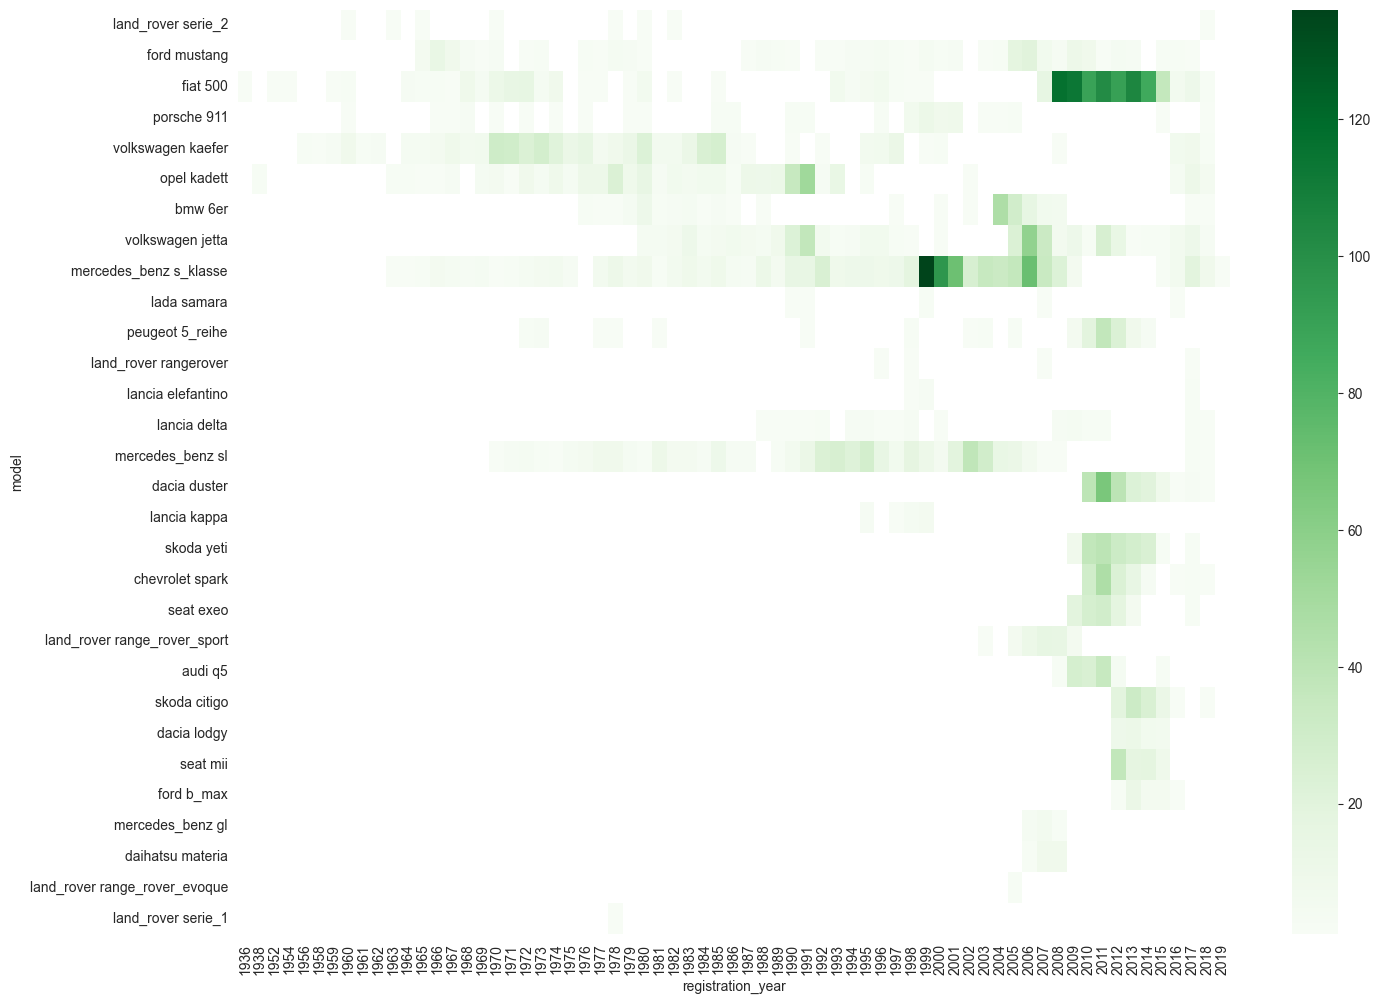

In [50]:
top_models = lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='std', ascending=False).index[:15].to_list() + lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='std', ascending=False).index[-15:].to_list()


fig, ax = plt.subplots(1, 1, figsize=(16, 12))
sns.heatmap(lifecycle[lifecycle['model'].isin(top_models)].pivot_table(values='price', index='model', columns='registration_year', aggfunc='count').reindex(top_models),
            cmap='Greens');
ax.grid(False)

В верхней половине графика модели с высокой дисперсией, в нижней - с низкой. Теперь посмотрим на дисперсию года выпуска массово выпускавшихся машин

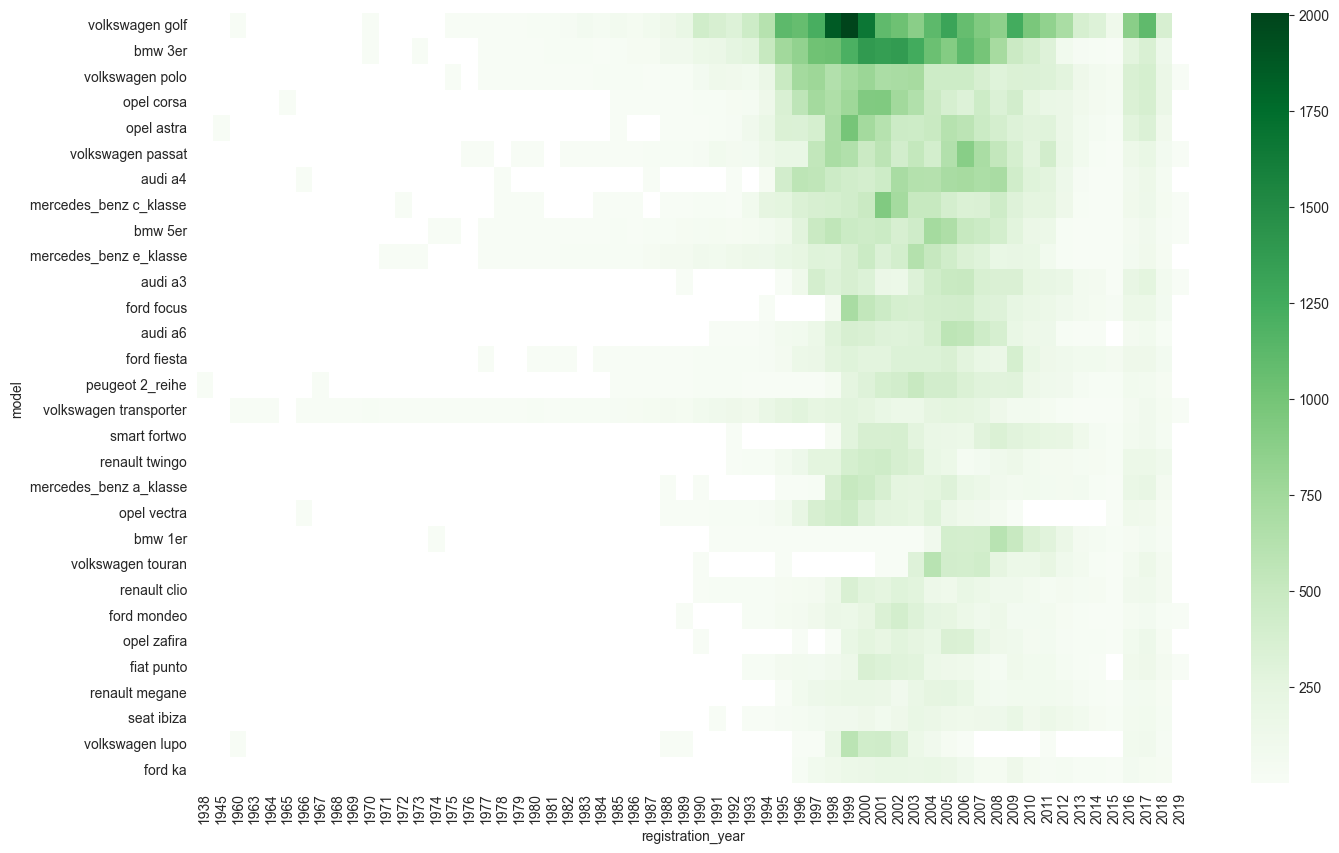

In [51]:
top_models = lifecycle.groupby('model')['registration_year'].agg(['count', 'std']).sort_values(by='count', ascending=False).index[:30].to_list()


fig, ax = plt.subplots(1, 1, figsize=(16, 10))
sns.heatmap(lifecycle[lifecycle['model'].isin(top_models)].pivot_table(values='price', index='model', columns='registration_year', aggfunc='count').reindex(top_models),
            cmap='Greens');
ax.grid(False)

Из двух графиков следует, что некоторые машины, такие как Фольксваген Транспортер стабильно равными партиями выпускаются в течение несколкьих десятков лет, другие становились популярны не сразу или переживали серьезную доработку (Фиат 500). К производству третьих компании впоследствии возвращались (Фольксваген Джетта). С другой стороны, в нашем распоряжении всего лишь выборка машин с сайта по их продаже, и пробелы на жизненном цикле линейки говорят лишь об отсутствии таких машин в продаже на данном сайте. В любом случае, делаем вывод о возможности замены года выпуска медианой (из-за скошенности данных). Но лишь в процессе кросс-валидации.

В данных много выбросов, заменим их на наны. За правую границу возьмем текущий год, но позже сравним год выпуска с имеющимися датами

In [52]:
df.loc[~df['registration_year'].between(1920, 2023), 'registration_year'] = np.nan

Посмотрим на зависимость цены от года выпуска машины. Есть предположение, что раритетные машины должны стоить также много, как и прошлогодние


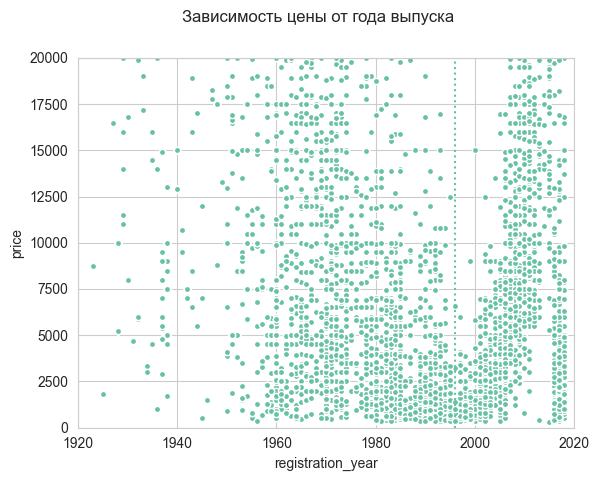

In [53]:
df.groupby(df['registration_year'].round(-1)).apply(lambda gr: gr.sample(555, replace=True)).reset_index(drop = True).plot(x='registration_year', y='price', kind='scatter', ec='w', color='#66c2a4');
plt.axvline(1996, color='#66c2a4', linestyle=':');
plt.ylim([0, 20000])
plt.xlim([1920, 2020])
plt.suptitle('Зависимость цены от года выпуска');

Так и есть! С наступлением тридцатилетия (действия происходят в 2016) автомобили начинают дорожать. Если этого не учесть, наступит парадокс Симпсона, когда общий тренд радикально отличаеся от трендов внутри кластера. Скорее всего бустинги бы заметили это и так, а вот для линейных моделей это будет неплохим булевым признаком. Кстати, на графике как будто прослеживается парабола, учтем это при обучении линейных моделей

In [54]:
df['vintage'] = df['registration_year']<1996

Посмотрим, сколько в каждом кластере наблюдений

In [55]:
df['vintage'].value_counts(normalize=True)

False    0.909785
True     0.090215
Name: vintage, dtype: float64

## gearbox

In [56]:
df['gearbox'].value_counts(dropna=False)

manual    249993
auto       64056
NaN        14422
Name: gearbox, dtype: int64

Заменим большинством

In [57]:
df['gearbox'].fillna('manual', inplace=True)

## power

У признака много выбросов.

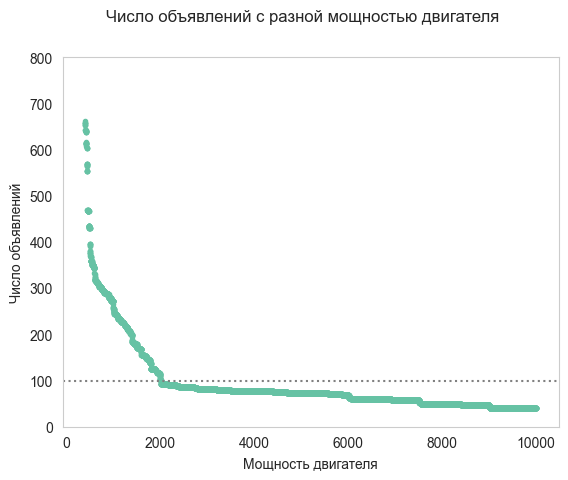

In [58]:
for thr in range(400, 10000):
    plt.plot(thr, df[df['power']>thr].shape[0], marker='.', color='#66c2a4')
    plt.grid(False)
plt.suptitle('Число объявлений с разной мощностью двигателя')
plt.ylim([0, 800])
plt.axhline(100, linestyle=':', color='grey');
plt.xlabel('Мощность двигателя')
plt.ylabel('Число объявлений');

Интересная неинтерпретируемая зависимость - объявления начинают слабее убывать примерно на отметке 2000 лс. Хотя и этот предел неадекватен мощности двигателя, можно предположить, что какие-то значения все же записаны в неправильных единицах измерения

Заменим все выбросы на Наны. Пусть адекватной мощностью двигателя будет диапазон 20...600 л.с

In [59]:
df.loc[~df['power'].between(20, 600), 'power'] = np.nan

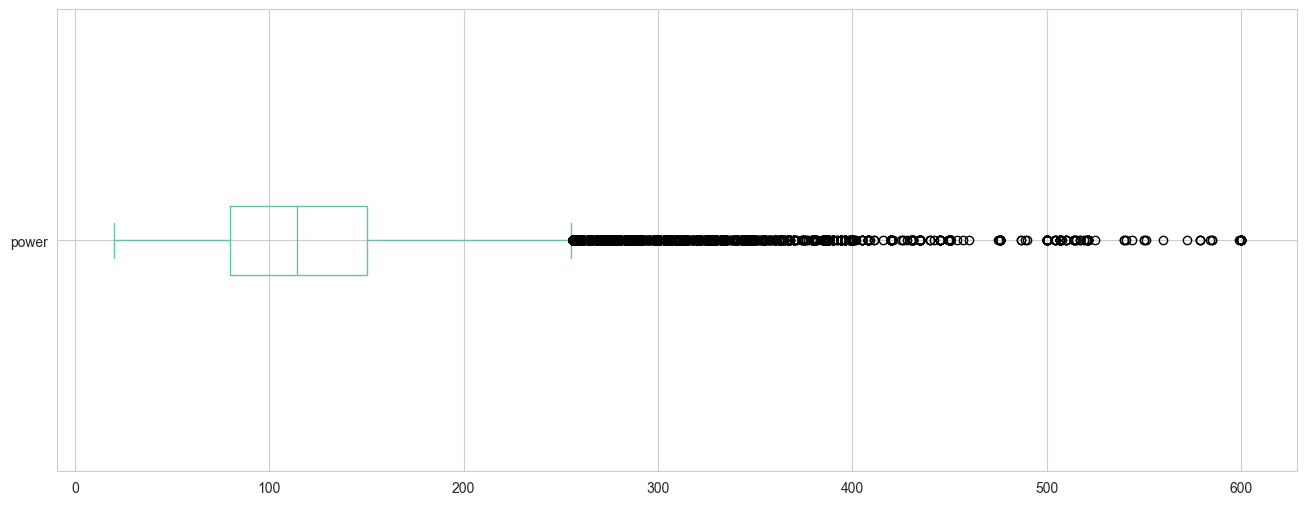

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
df['power'].plot.box(grid=True, vert=False, color='#66c2a4', ax=ax);

## kilometer

In [61]:
df['kilometer'].value_counts()

150000    219042
125000     34788
100000     13993
90000      11175
80000       9753
70000       8376
60000       7303
50000       6086
40000       4815
30000       4240
5000        4189
20000       3652
10000       1059
Name: kilometer, dtype: int64

Значения дискретны, и значение 150000 несет смысл "более 150 тыс км". закодируем их через OrdinalEncoder.

## registration_month

In [62]:
df['registration_month'].value_counts()

3     32686
6     29899
4     27728
5     27596
0     27467
7     25908
10    24942
11    23159
12    23079
9     22718
1     21714
8     21509
2     20066
Name: registration_month, dtype: int64

Месяцев получилось тринадцать! Наверное, значение 0 можно интерпретировать как "неизвестно", тем более его значение немного превышает все остальные. Сам по себе месяц выпуска/регистрации машины не должен ни с чем коррелировать, но вот информация о том, известен ли месяц, может означать наличие нормальных документов на машину. Попробуем закодировать этот признак бинарно дополнительно к основному (банарная кодировка сильнее коррелирует с таргетом, это будет видно дальше), а потом спросим у заказчика, что это всё значит и откуда брать признак для будущих объявлений

In [63]:
df['registration_month_bool'] = df['registration_month']>0

## fuel_type

In [64]:
df['fuel_type'].value_counts(dropna=False, normalize=True)

petrol      0.610511
gasoline    0.293974
NaN         0.077014
lpg         0.015505
cng         0.001641
hybrid      0.000685
other       0.000414
electric    0.000256
Name: fuel_type, dtype: float64

В списке отсутствует дизель, но понадеемся, что он скрывается за одним из терминов gasoline/petrol, потому что если переводить дословно, то оба они - бензин. А вот маленькие категории объединим в other

Заполним тип топлива наиболее частым для данной модели

In [65]:
grouper(data=df, columns_group='model', column_res='fuel_type').head(44)

fuel_type
model             fuel_type           
alfa_romeo 145    petrol            31
alfa_romeo 147    gasoline         132
                  lpg               17
                  petrol           384
alfa_romeo 156    gasoline         179
                  lpg               14
                  petrol           323
alfa_romeo 159    gasoline         138
                  petrol            58
alfa_romeo other  gasoline         126
                  lpg                3
                  petrol           398
alfa_romeo spider gasoline          11
                  lpg                1
                  petrol           164
audi 100          gasoline          15
                  lpg                8
                  petrol           323
audi 200          petrol            16
audi 80           gasoline          76
                  lpg               21
                  petrol          1126
audi 90           petrol            74
audi a1           gasoline         171
                  petrol           413
audi a2           gasoline         157
                  petrol           205
audi a3           gasoline        2367
                  lpg               38
                  petrol          3282
audi a4           electric           2
                  gasoline        4709
                  hybrid             1
                  lpg              132
                  other              1
                  petrol          4127
audi a5           gasoline         326
                  petrol           195
audi a6           cng                1
                  gasoline        3427
                  lpg              158
                  petrol          1468
audi a8           gasoline         220
                  lpg               42

In [66]:
print(f'Нанов было {df["fuel_type"].isna().sum()}')
df = filler(data=df, columns_group='model', column_res='fuel_type')
print(f'Осталось {df["fuel_type"].isna().sum()} Нанов')

Нанов было 25297
Осталось 0 Нанов


Остатки заполним

In [67]:
df.loc[df['fuel_type'].isin(['lpg', 'cng', 'hybrid', 'electric']), 'fuel_type'] = 'other'

Посмотрим, что получилось

In [68]:
df['fuel_type'].value_counts(dropna=False, normalize=True)

petrol      0.673834
gasoline    0.307665
other       0.018501
Name: fuel_type, dtype: float64

## not_repaired

In [69]:
df['not_repaired'].value_counts(dropna=False)

no     240479
NaN     58821
yes     29171
Name: not_repaired, dtype: int64

Отнесем наны к неремонтированным машинам

In [70]:
df['not_repaired'] = df['not_repaired'].fillna('yes')

In [71]:
df['not_repaired'] = df['not_repaired'].replace({'yes': 1, 'no': 0}).astype('bool')

## date_created и last_seen

Переведем колонки в тип даты

In [72]:
df['date_created'] = pd.to_datetime(df['date_created'])
df['last_seen'] = pd.to_datetime(df['last_seen'])

В датасете несколько столбцов с датами, давайте проверим, все ли даты правильно упорядочены во времени

In [73]:
df[~((df['registration_year']<=df['date_created'].dt.year) &
   (df['date_created'].dt.year<=df['last_seen'].dt.year) &
   (df['last_seen'].dt.year<=df['date_crawled'].dt.year))]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,postal_code,last_seen,latitude,longitude,population,vintage,registration_month_bool
15,2016-03-11 21:39:15,450,small,NaN,manual,NaN,ford ka,5000,0,petrol,ford,True,2016-03-11,24148,2016-03-19 08:46:47,54.318700,10.170300,246601.0,False,False
22,2016-03-23 14:52:51,2900,bus,2018.0,manual,90.0,opel meriva,150000,5,petrol,opel,False,2016-03-23,49716,2016-03-31 01:16:33,52.690600,7.291000,34198.0,False,True
26,2016-03-10 19:38:18,5555,sedan,2017.0,manual,125.0,citroen c4,125000,4,gasoline,citroen,False,2016-03-10,31139,2016-03-16 09:16:46,52.141000,9.940700,103052.0,False,True
48,2016-03-25 14:40:12,7750,sedan,2017.0,manual,80.0,volkswagen golf,100000,1,petrol,volkswagen,True,2016-03-25,48499,2016-03-31 21:47:44,52.325600,7.430500,7602.0,False,True
51,2016-03-07 18:57:08,2000,small,2017.0,manual,90.0,fiat punto,150000,11,gasoline,fiat,True,2016-03-07,66115,2016-03-07 18:57:08,49.239900,6.969600,179349.0,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354112,2016-03-11 15:49:51,3600,bus,2017.0,manual,86.0,ford transit,150000,5,gasoline,ford,True,2016-03-11,32339,2016-03-12 05:45:02,52.382500,8.621300,26378.0,False,True
354140,2016-03-29 16:47:29,1000,wagon,2017.0,manual,101.0,audi a4,150000,9,gasoline,audi,True,2016-03-29,38315,2016-04-06 02:44:27,52.034850,10.543900,NaN,False,True
354203,2016-03-17 00:56:26,2140,small,2018.0,manual,80.0,ford fiesta,150000,6,petrol,ford,False,2016-03-17,44866,2016-03-29 15:45:04,51.480800,7.148600,385729.0,False,True
354253,2016-03-25 09:37:59,1250,small,2018.0,manual,NaN,opel corsa,150000,0,petrol,opel,True,2016-03-25,45527,2016-04-06 07:46:13,51.400000,7.166700,56866.0,False,False


Почти 15 тыс объявлений не упорядочены. Без лишних выкладок скажем, что во всех них дата регистрации позже даты создания объявления, последнего посещения и его скачивания. Заменим в таких объявлениях год регистрации на nan

In [74]:
df.loc[~((df['registration_year']<=df['date_created'].dt.year) &
   (df['date_created'].dt.year<=df['last_seen'].dt.year) &
   (df['last_seen'].dt.year<=df['date_crawled'].dt.year)), 'registration_year'] = np.nan

Наконец, удалим вспомогательные столбцы и посмотрим, что осталось от датасета

In [75]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code'], axis=1)

In [76]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
price,328471,0,int64,328471.0,4756.24337,4517.209198,301.0,1350.0,3000.0,6800.0,20000.0
vehicle_type,328471,0,object,,,,,,,,
registration_year,315009,13462,float64,315009.0,2002.785632,6.752968,1923.0,1999.0,2003.0,2007.0,2016.0
gearbox,328471,0,object,,,,,,,,
power,296555,31916,float64,296555.0,121.67082,53.64183,20.0,80.0,114.0,150.0,600.0
model,328471,0,object,,,,,,,,
kilometer,328471,0,int64,328471.0,128301.326449,37160.167991,5000.0,125000.0,150000.0,150000.0,150000.0
registration_month,328471,0,int64,328471.0,5.867175,3.662016,0.0,3.0,6.0,9.0,12.0
fuel_type,328471,0,object,,,,,,,,
brand,328471,0,object,,,,,,,,


В годе выпуска и мощности двигателя пропусков не было, а теперь появились из-за переноса выбросов в нан. Со всем остальным наоборот, пропуски удалось заполнить

## Корреляции признаков

Посмотрим, как коррелируют друг с другом числовые признаки

CPU times: total: 18 s
Wall time: 18.1 s


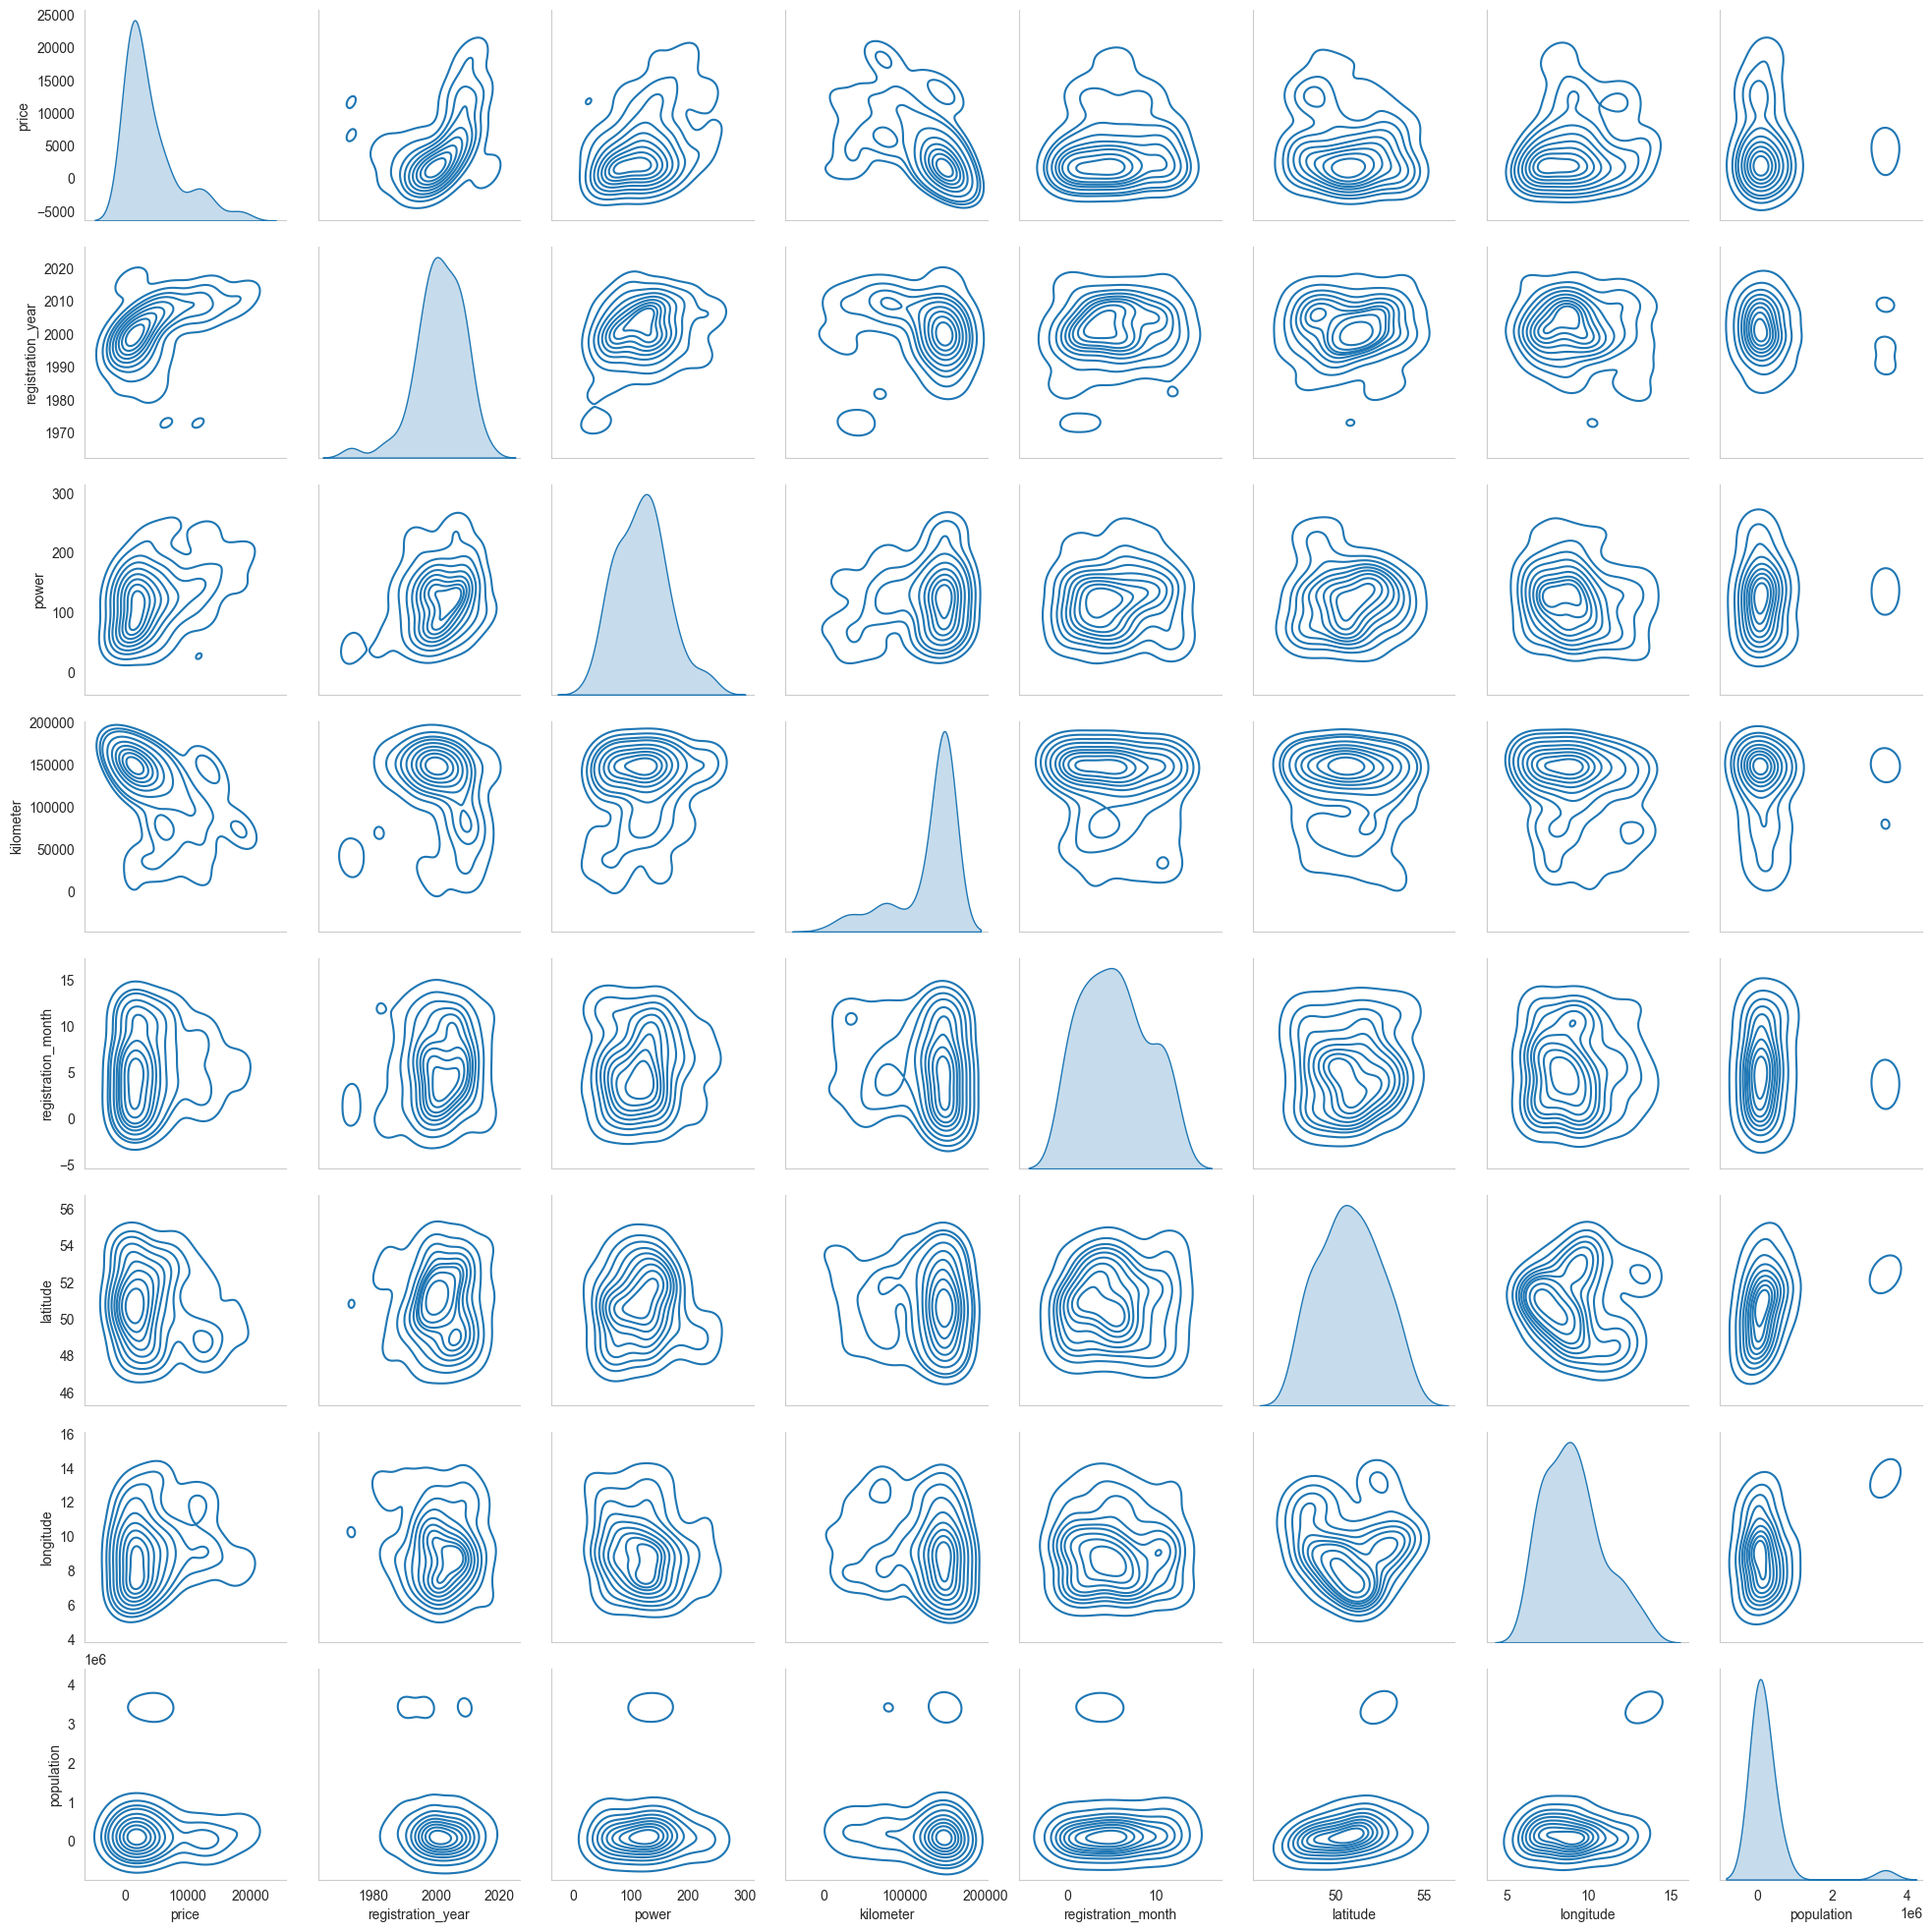

In [77]:
%%time
sns.set_style("whitegrid", {'axes.grid' : False})
sns.pairplot(df.select_dtypes(exclude=['object', 'bool']).sample(111), kind='kde');

Посмотрим на значения коэффициента линейной корреляции

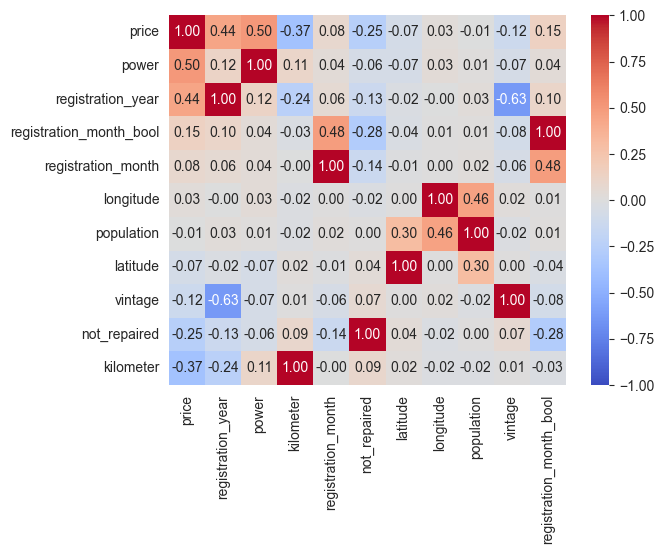

In [78]:
sns.heatmap(df.select_dtypes(exclude='object').corr().sort_values('price', ascending=False),
            vmin=-1, vmax=1,
            cmap='coolwarm',
            annot=True,
            fmt='.2f');

А теперь посмотрим на нелинейные корреляции

interval columns not set, guessing: ['price', 'registration_year', 'power', 'kilometer', 'registration_month', 'latitude', 'longitude', 'population']


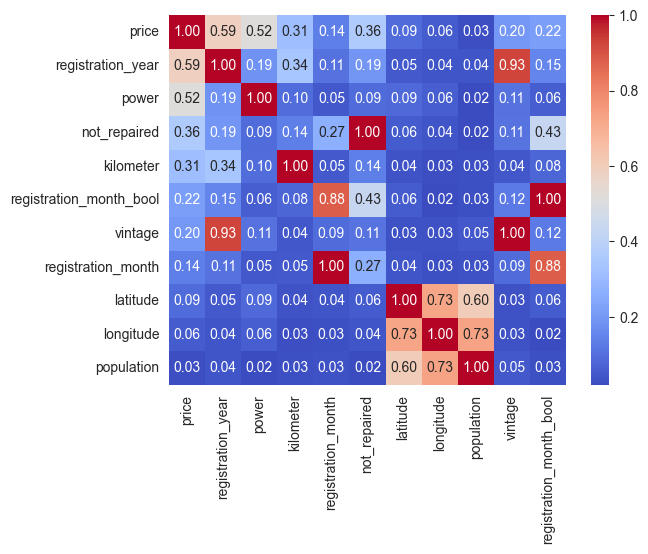

In [79]:
sns.heatmap(df.select_dtypes(exclude='object').phik_matrix().sort_values('price', ascending=False),
            cmap='coolwarm',
            annot=True,
            fmt='.2f');

По обоим хитмэпам видно, что геоданные, которые мы так тщательно добывали, коррелируют только друг с другом. Но зато месяц регистрации, который мы закодировали бинарно, имеет неплохую корреляцию, его и оставим

In [80]:
try:
    df = df.drop(['registration_month', 'latitude', 'longitude', 'population'], axis=1).reset_index(drop=True)
except:
    pass

Посмотрим на свгдную информацию по обработанному датасету

In [81]:
full_info(df)

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
price,328471,0,int64,328471.0,4756.24337,4517.209198,301.0,1350.0,3000.0,6800.0,20000.0
vehicle_type,328471,0,object,,,,,,,,
registration_year,315009,13462,float64,315009.0,2002.785632,6.752968,1923.0,1999.0,2003.0,2007.0,2016.0
gearbox,328471,0,object,,,,,,,,
power,296555,31916,float64,296555.0,121.67082,53.64183,20.0,80.0,114.0,150.0,600.0
model,328471,0,object,,,,,,,,
kilometer,328471,0,int64,328471.0,128301.326449,37160.167991,5000.0,125000.0,150000.0,150000.0,150000.0
fuel_type,328471,0,object,,,,,,,,
brand,328471,0,object,,,,,,,,
not_repaired,328471,0,bool,,,,,,,,


* Осталось 11 признаков: 5 категориальных, 3 численных и 3 булевых
* Пропуски остались в двух численных признаках. Это последствия заполнения нанами выбросов

# Разделение на обучающую и тестовую выборки

In [82]:
x = df.drop('price', axis=1)
y = df['price']

In [83]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=rs)

# Создание кастомной метрики

In [84]:
def rmse(y_true, y_pred):
    return (mean_squared_error(y_true, y_pred, squared=False))
rmse_score = make_scorer(rmse, greater_is_better=False)

# Написание пользовательских классов

Категориальные признаки перед подстановкой в модель нужно привести к численным. Для этого используются различные трансформеры. Самый очевидный трансформер, Ohe-Hot-Encoding, уже встроен в sklearn, но из-за высокой кардинальности (числа категорий) некоторых признаков может наступить проклятие размерности, когда из-за роста числа признаков снижается обобщающая способность на разреженной матрице данных. Так что добавим к рассмотрению еще один трансформер, который будет шифрует категорию числом упоминания её в обучающей выборке. Прочие трансформеры тестировать не будем из-за ограниченности вычислительных ресурсов.

## FrequencyEncoder

In [85]:
# https://medium.com/@benlc77/how-to-write-clean-and-scalable-code-with-custom-transformers-sklearn-pipelines-ecb8e53fe110

class FrequencyEncoder(BaseEstimator, TransformerMixin):
    # наследуемся от BaseEstimator, TransformerMixin, чтобы были базовые методы фит-трансформ и get_params
    def __init__(self):
        pass

    def fit(self, x, y=None):
        vc = []
        self.x = x
        self.features = x.columns
        for feature in self.features:
            vc.append(x[feature].value_counts())
        self.vc = vc
        return self

    def transform(self, x, y=None):
        # нолики
        x_tr = np.zeros(shape=x.shape[0])
        for feature, t in zip(self.features, self.vc):
            x_tr = np.vstack([x_tr, x[feature].transform(lambda i: t.loc[i] if i in t.index else 0)])

        # Первая строчка нолики, со второй - трансформированные фичи
        return x_tr[1:].T

Внутри пайплайна сложно передавать имена столбцов, так как трансфмормеры приводят все таблицы в формат numpy. Поэтому чтобы заработал наш следующий класс, нужно сделать вспомогательный трансфомер, который просто будем ставить выбранный признак первым по счету в датасете.

In [86]:
# Нужен для того, чтобы искомый столбец встал первым по счету

class LazyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, x, y=None):
        return self

    def transform(self, x, y=None):
        return x

Напишем класс, который будет разделять датасет по определенному категориальному признаку и строить свою линейную регрессию для каждого уникального значения в этой категории - своеобразный биннинг. А еще добавим возможность приводить выбивающиеся за разумные рамки значения к установленным границам

In [87]:
# МОЖНО ПОПРОБОВАТЬ ДЕЛИТЬ ДАТАСЕТ ПО ПЕРВОМУ ПРИЗНАКУ, А В ТРАНСФОРМЕР НА ПЕРВОМ МЕСТЕ ПОСТАВИТЬ ТРАНСФОМЕР, КОТОРЫЙ ВОЗВРАЩАЕТ ПРИЗНАК БЕЗ ИЗМЕНЕНИЙ
# Класс может работать в нескольких сценариях. Примеры после объявления
class BinClipPowerLinearRegression():
    def __init__(self, feature=None, columns=None, take_first=False, clip=False, power=1):
        # Если передается датафрейм, то достаточно указать признак. А если нп.аррей, то нужно дать названия колонкам
        # Если take_first=True, то берется первый столбец
        self.columns=columns
        self.take_first=take_first
        self.power = power
        if self.columns and feature: # проверяем не называется ли фича теперь как-то по-другому, ищем имя типа num_ct__feature
            self.feature = [i for i in columns if feature in i][0]
        elif feature:
            self.feature = feature
        else:
            self.feature = 0
        self.clip = clip

    def fit(self, x, y, ymin=y.min(), ymax=y.max()):
        if self.take_first:
            self.columns = [i for i in range(x.shape[1])]

        if self.columns:
            if type(x) == np.ndarray:
                x = pd.DataFrame(x, columns=self.columns)
            elif type(x) == pd.DataFrame:
                x.columns = self.columns
            else:
                x = pd.DataFrame(x.toarray(), columns=self.columns)
            x = x.reset_index(drop=True)

            try: # это если передан Series с индексами
                y = y.reset_index(drop=True)
            except: # а это если любая другая структура без индексов
                pass
        self.uniques = x[self.feature].unique()
        self.ymin = ymin
        self.ymax = ymax
        models = {}

        for f in self.uniques:
            xx = x[x[self.feature]==f]
            yy = y[xx.index]
            models[f] = LinearRegression().fit(xx, yy**(1/self.power))
        self.models = models

        return self

    def predict(self, x):
        if self.columns:
            if type(x) == np.ndarray:
                x = pd.DataFrame(x, columns=self.columns)
            elif type(x) == pd.DataFrame:
                pass
            else:
                x = pd.DataFrame(x.toarray(), columns=self.columns)
        x = x.reset_index(drop=True)

        # создаем пустую матрицу
        y_pred = np.full([x.shape[0], 1], np.nan)
        for f in self.uniques:
            try:
                y_pred[x[x[self.feature]==f].index, :] = self.models[f].predict(x[x[self.feature]==f]).reshape(-1, 1)
            except:
                pass
        # Заполнение нанов медианой, если вдруг на тестовой выборке встретилась категория, которой не было на обучении
        y_pred[np.where(np.isnan(y_pred))] = np.nanmedian(y_pred)

        if self.clip:
            return np.clip(y_pred**self.power, self.ymin, self.ymax)
        return y_pred ** self.power

Проверим работоспособность этого дьявольского класса в шести сценариях на примере урезанного датасета, состоящего всего из двух признаков:

Передаем датафрейм и указываем признак, по которому будем делить датасет

In [88]:
tmp1 = x_train[['registration_year', 'vintage' ]].fillna(2000)
bclr1 = BinClipPowerLinearRegression(feature='vintage')
tmp_pred1 = bclr1.fit(tmp1, y_train).predict(tmp1)
rmse(y_train, tmp_pred1)

3596.2476375558936

Передаем датафрейм и указываем, что делить нужно по первому признаку

In [89]:
tmp2 = x_train[['vintage', 'registration_year']].fillna(2000)
bclr2 = BinClipPowerLinearRegression(take_first=True)
tmp_pred2 = bclr2.fit(tmp2, y_train).predict(tmp2)
rmse(y_train, tmp_pred2)

3596.2476375558936

Передаем нп.аррей и имена колонок

In [90]:
tmp3 = x_train[['registration_year', 'vintage' ]].fillna(2000).values
columns3 = ['registration_year', 'vintage' ]
bclr3 = BinClipPowerLinearRegression(columns=columns3, feature='vintage')
tmp_pred3 = bclr3.fit(tmp3, y_train).predict(tmp3)
rmse(y_train, tmp_pred3)

3596.2476375558936

Передаем нп.аррей и просим взять первый столбец

In [91]:
tmp4 = x_train[['vintage', 'registration_year']].fillna(2000).values
columns4 = ['vintage', 'registration_year']
bclr4 = BinClipPowerLinearRegression(columns=columns4, take_first=True)
tmp_pred4 = bclr4.fit(tmp4, y_train).predict(tmp4)
rmse(y_train, tmp_pred4)

3596.2476375558936

Передаем scipy.sparse_matrix и просим взять первый столбец

In [92]:
tmp5 = sparse.csr_matrix(x_train[['vintage', 'registration_year']].fillna(2000).values.astype('float'))
columns5 = ['vintage', 'registration_year']
bclr5 = BinClipPowerLinearRegression(columns=columns5, take_first=True)
tmp_pred5 = bclr5.fit(tmp5, y_train).predict(tmp5)
rmse(y_train, tmp_pred5)

3596.2476375558936

Передаем scipy.sparse_matrix и указываем признак

In [93]:
tmp6 = sparse.csr_matrix(x_train[['vintage', 'registration_year']].fillna(2000).values.astype('float'))
columns6 = ['vintage', 'registration_year']
bclr6 = BinClipPowerLinearRegression(columns=columns6, feature='vintage', power=1, clip=True)
tmp_pred6 = bclr6.fit(tmp6, y_train).predict(tmp6)
rmse(y_train, tmp_pred6)

3596.2476375558936

Посмотрим теперь, какие предсказания дала бы простая линейная регрессия

In [94]:
bclr7 = LinearRegression()
bclr7_pred = bclr7.fit(tmp1, y_train).predict(tmp1)
rmse(y_train, bclr7_pred)

3964.6182732743287

Скоры одинаковые, прирост точности наблюдается. Ошибки не всплыли, значит во всех применениях, включая сильно разреженные матрицы наша регрессия работает красиво. А теперь посмотрим, что можно сделать еще. На этапе разведочного анализа мы выявили квадратичную зависимость между годом выпуска и стоимостью как винтажных, так и обычных машин. Попробуем при помощи нашего класса восстановить эту зависимость

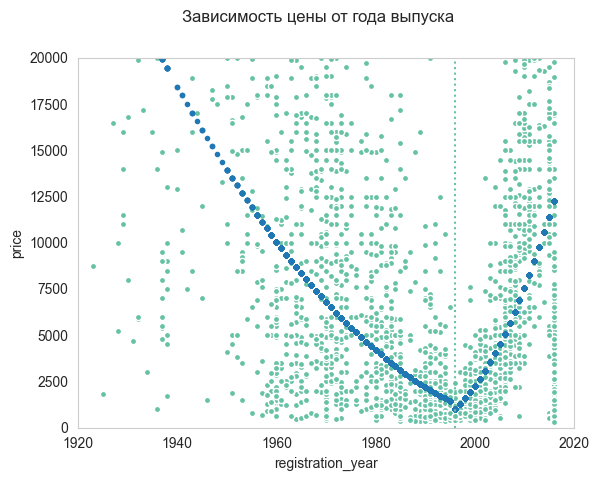

In [95]:
bclr8 = BinClipPowerLinearRegression(feature='vintage', power=2)
bclr8_pred = bclr8.fit(tmp1, y_train).predict(tmp1)

df.groupby(x_train['registration_year'].round(-1)).apply(lambda gr: gr.sample(300, replace=True)).reset_index(drop = True).plot(x='registration_year', y='price', kind='scatter', ec='w', color='#66c2a4');
plt.scatter(x=x_train['registration_year'], y=bclr8_pred, marker='.');
plt.axvline(1996, color='#66c2a4', linestyle=':');
plt.ylim([0, 20000])
plt.xlim([1920, 2020])
plt.suptitle('Зависимость цены от года выпуска');

In [96]:
rmse(y_train, bclr8_pred)

3720.5771438662514

Визуально кривые стали лучше описывать скаттерплот, но метрика упала. Видимо это попытка выдать желаемое за действительное. Но не будем отчаиваться, ведь это двухпризнаковый датасет, и в бою еще могут себя проявить такие фичи класса, как power и clip.

# Обучение моделей

Создадим таблицу, в которую будем заносить время обучения, инференса (одного наблюдения) и скор на обучающей и тестовой выборках для всех рассматриваемых моделей

In [97]:
results = pd.DataFrame(columns=('train_rmse', 'train_time', 'test_rmse', 'inference_time' ))

И функцию по ее заполнению

In [98]:
def result_table(estimator, alias, x_train, x_test, y_train, y_test, scoring=rmse):
    start = time.time()
    estimator.fit(x_train, y_train)
    results.loc[alias, 'train_time'] = time.time() - start

    results.loc[alias, 'train_rmse'] = scoring(y_train, estimator.predict(x_train))

    results.loc[alias, 'test_rmse'] = scoring(y_test, estimator.predict(x_test))

    start = time.time()
    estimator.predict(x_train.sample())
    results.loc[alias, 'inference_time'] = time.time() - start

## Линейная регрессия

Начнем с самой простой линейной регрессии. Создадим пайплайн, который будет заполнять пропуски средним/медианой/самым частым значением. Числовые признаки будут отмасштабированы в зависимости от того, есть ли в признаке выбросы.

In [99]:
num_ct_robust = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', RobustScaler(quantile_range=(15, 85)))])

num_ct_standard = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                  ('scaler', StandardScaler())])

cat_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                         ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'))])

transformer = ColumnTransformer(transformers=[('nums_robust', num_ct_robust, ('registration_year', 'power',)),
                                              ('nums_standard', num_ct_standard, ('kilometer', )),
                                              ('cats', cat_ct, selector(dtype_include='object'))],
                                remainder='passthrough')

lr_pipe = Pipeline([('transformer', transformer), ('estimator', LinearRegression())])

In [100]:
%%time
cross_val_score(lr_pipe, x_train, y_train, scoring=rmse_score, cv=3, n_jobs=-1, error_score='raise').mean().round()

CPU times: total: 422 ms
Wall time: 5.62 s


-2673.0

Занесем результат в таблицу

In [101]:
with warnings.catch_warnings():
    result_table(lr_pipe, 'LinearRegression', x_train, x_test, y_train, y_test, scoring=rmse)

C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Значение метрики выглядит приемлемо (отрицательное значение возникло из-за того, что максимизируется отрицательное число), но посмотрим на гистограмму

In [102]:
cv_lr_pred = cross_val_predict(lr_pipe, x_train, y_train, cv=3, n_jobs=-1)

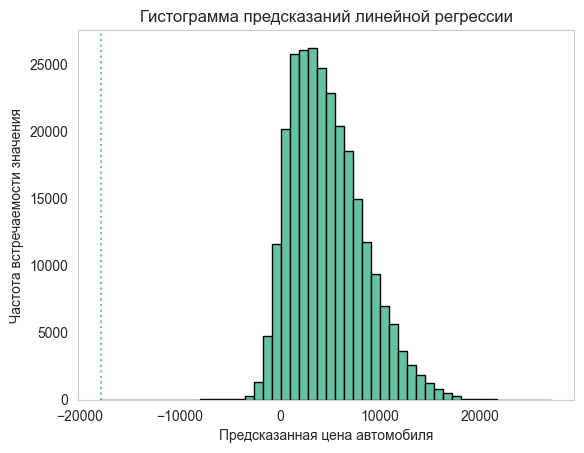

In [103]:
plt.hist(cv_lr_pred, bins=50, ec='k', color='#66c2a4');
plt.axvline(cv_lr_pred.min(), color='#66c2a4', linestyle=':');
plt.xlabel('Предсказанная цена автомобиля')
plt.ylabel('Частота встречаемости значения');
plt.title('Гистограмма предсказаний линейной регрессии');

Регрессия ожидаемо выдала большое количество отрицательных значений. Посмотрим, что это за значения

In [104]:
tmp = x_train.reset_index(drop=True).loc[np.where(cv_lr_pred<300)[0], :].assign(price = y_train.reset_index(drop=True), price_pred=pd.Series(cv_lr_pred))
tmp['abs_diff'] = tmp['price'] - tmp['price_pred']

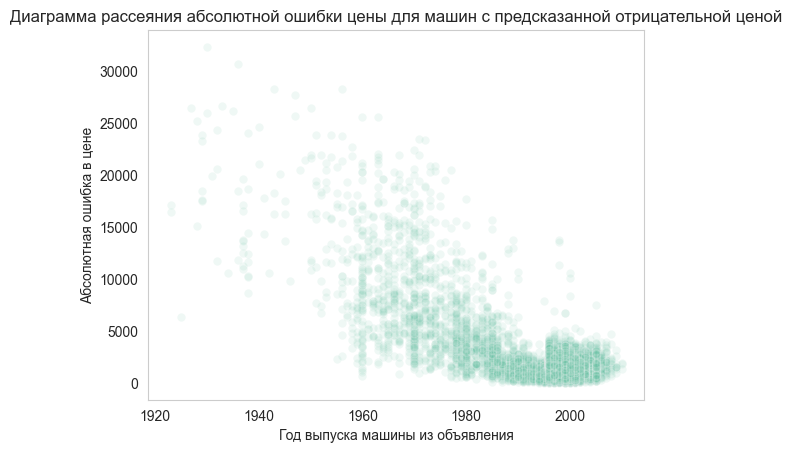

In [105]:
plt.scatter(x=tmp['registration_year'], y=tmp['abs_diff'], color='#66c2a4', alpha=0.1, ec='w');
plt.xlabel('Год выпуска машины из объявления')
plt.ylabel('Абсолютная ошибка в цене');
plt.title('Диаграмма рассеяния абсолютной ошибки цены для машин с предсказанной отрицательной ценой');

График показывает, что модель довольно сильно ошибается на винтажных авто, предсказывая низкое или вообще отрицательное значение. Тут-то нам и поможет биннинг (не уверен, что тут корректно использую это понятие) по признаку винтажности

Напишем пайплайн преобразований для каждого признака и испытаем его на модели простой регрессии и BinClipPowerLinearRegression. Для каждого признака придется отдельно прописывать свой трансфомер

In [106]:
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                         ('scaler', RobustScaler(quantile_range=(15, 85)))])
lazy = LazyEncoder() # это для BinPowerClipLinearRegression

# Пришлось сделать пайплайн для каждого признака, потому что планируется в гридсерч включить FrequencyEncoder, а он переведет категории в числа и потребует стандартизации
vehicle_type_ct = Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
                                  ('scaler', StandardScaler(with_mean=False))])
gearbox_ct =      Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
                                  ('scaler', StandardScaler(with_mean=False))])
model_ct =        Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
                                  ('scaler', StandardScaler(with_mean=False))])
fuel_type_ct =    Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
                                  ('scaler', StandardScaler(with_mean=False))])
brand_ct =        Pipeline(steps=[('encoder', OneHotEncoder(drop='first', handle_unknown='ignore')),
                                  ('scaler', StandardScaler(with_mean=False))])

transformer = ColumnTransformer(transformers=[('lazy', lazy, ('vintage',)),
                                              ('vehicle_type_ct', vehicle_type_ct, ('vehicle_type', )),
                                              ('gearbox_ct', gearbox_ct, ('gearbox', )),
                                              ('model_ct', model_ct, ('model', )),
                                              ('fuel_type_ct', fuel_type_ct, ('fuel_type', )),
                                              ('brand_ct', brand_ct, ('brand', )),
                                              ('num_ct', num_ct, selector(dtype_exclude='object')),
                                              ],
                                remainder='passthrough')

lr_pipe = Pipeline([('transformer', transformer), ('estimator', LinearRegression())])

# BinClipPowerLinearRegression(take_first=True, clip=True, power=2)

In [107]:
lr_params = {
            'transformer__num_ct__imputer__strategy': ['mean', 'median'],
            'transformer__num_ct__scaler': [StandardScaler(), RobustScaler(quantile_range=(5, 95))],
         #  'transformer__vehicle_type_ct__encoder': [OneHotEncoder(), FrequencyEncoder()],
         #  'transformer__gearbox_ct__encoder': [OneHotEncoder(), FrequencyEncoder()],
            'transformer__model_ct__encoder': [OneHotEncoder(drop='first', handle_unknown='ignore'), FrequencyEncoder()],
         #  'transformer__fuel_type_ct__encoder': [OneHotEncoder(), FrequencyEncoder()],
            'transformer__brand_ct__encoder': [OneHotEncoder(drop='first', handle_unknown='ignore'), FrequencyEncoder()],
            'estimator': [LinearRegression(),
                        # BinClipPowerLinearRegression(take_first=True, clip=False, power=1),
                        # BinClipPowerLinearRegression(take_first=True, clip=True, power=1),
                        # BinClipPowerLinearRegression(take_first=True, clip=False, power=2),
                        BinClipPowerLinearRegression(take_first=True, clip=True, power=2)
                        ]
            }

lr_params = {
            # 'transformer__num_ct__imputer__strategy': ['mean', 'median'],
            # 'transformer__num_ct__scaler': [StandardScaler(), RobustScaler(quantile_range=(5, 95))],
         #  'transformer__vehicle_type_ct__encoder': [OneHotEncoder(), FrequencyEncoder()],
         #  'transformer__gearbox_ct__encoder': [OneHotEncoder(), FrequencyEncoder()],
            'transformer__model_ct__encoder': [OneHotEncoder(drop='first', handle_unknown='ignore')],
         #  'transformer__fuel_type_ct__encoder': [OneHotEncoder(), FrequencyEncoder()],
            'transformer__brand_ct__encoder': [FrequencyEncoder()],
            'estimator': [
                        # LinearRegression(),
                        # BinClipPowerLinearRegression(take_first=True, clip=False, power=1),
                        # BinClipPowerLinearRegression(take_first=True, clip=True, power=1),
                        # BinClipPowerLinearRegression(take_first=True, clip=False, power=2),
                        BinClipPowerLinearRegression(take_first=True, clip=True, power=2)
                        ]
            }

lr_gs    = GridSearchCV(estimator=lr_pipe,
                        param_grid=lr_params,
                        scoring=rmse_score,
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10,
                        error_score='raise')

In [108]:
%%time
lr_gs.fit(x_train, y_train)
lr_estimator = lr_gs.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: total: 39.7 s
Wall time: 31.9 s


In [109]:
display(pd.DataFrame(lr_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1].head(10))

,rank_test_score,std_test_score,mean_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_transformer__model_ct__encoder,param_transformer__brand_ct__encoder,param_estimator,std_score_time,mean_score_time,std_fit_time,mean_fit_time
0,1,5.561318,-2321.037947,-2324.98373,-2324.957042,-2313.17307,{'estimator': <__main__.BinClipPowerLinearRegr...,"OneHotEncoder(drop='first', handle_unknown='ig...",FrequencyEncoder(),<__main__.BinClipPowerLinearRegression object ...,0.053116,2.31981,0.406631,15.909555


Основной прирост относительно простой регрессии и OHE дал новый класс эстимейтора. Но и FrequencyEncoder себя немножко проявил. Двигаемся дальше

In [110]:
result_table(lr_estimator, 'BinClipPowerLinearRegression', x_train, x_test, y_train, y_test, scoring=rmse)

C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


## Случайный лес

По идее, деревянные модели не должны экстраполировать данные, то есть ожидаем, что все предсказанные цены будут в диапазоне [300, 20000]. Модели sklearn все равно не умеют напрямую работать с категориальными признаками, поэтому им также требуются трансформеры. Лес довольно долго учится, поэтому в финальной версии оставлены только пара основных гиперпараметров с оптимальными значениями. Бессмысленно оптимизировать леса, если впереди бустинги.

In [111]:
num_ct = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])

transformer = ColumnTransformer(transformers=[
                                              ('vehicle_type_ct', OneHotEncoder(drop='first', handle_unknown='ignore'), ('vehicle_type', )),
                                              ('gearbox_ct', OneHotEncoder(drop='first', handle_unknown='ignore'), ('gearbox', )),
                                              ('model_ct', OneHotEncoder(drop='first', handle_unknown='ignore'), ('model', )),
                                              ('fuel_type_ct', OneHotEncoder(drop='first', handle_unknown='ignore'), ('fuel_type', )),
                                              ('brand_ct', OneHotEncoder(drop='first', handle_unknown='ignore'), ('brand', )),
                                              ('num_ct', num_ct, selector(dtype_exclude='object')),
                                              ],
                                remainder='passthrough')

rf_pipe = Pipeline([('transformer', transformer), ('estimator', RandomForestRegressor(random_state=rs))])

In [112]:
rf_params = {
             'transformer__model_ct': [OneHotEncoder(drop='first', handle_unknown='ignore')],
             'transformer__brand_ct': [FrequencyEncoder()],
             'estimator__n_estimators': [20],
             'estimator__max_depth': [9],
            }

rf_gs    = GridSearchCV(estimator=rf_pipe,
                        param_grid=rf_params,
                        scoring=rmse_score,
                        refit=True,
                        cv=3,
                        n_jobs=-1,
                        verbose=10,
                        error_score='raise')

In [113]:
%%time
rf_gs.fit(x_train, y_train)
rf_best_estimator = rf_gs.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
CPU times: total: 50.1 s
Wall time: 1min 32s


In [114]:
display(pd.DataFrame(rf_gs.cv_results_).sort_values('rank_test_score').loc[:, ::-1].head(10))
print(f'параметры: {rf_gs.best_params_}',
      f'\nrmse: {rf_gs.best_score_:.4f}')

,rank_test_score,std_test_score,mean_test_score,split2_test_score,split1_test_score,split0_test_score,params,param_transformer__model_ct,param_transformer__brand_ct,param_estimator__n_estimators,param_estimator__max_depth,std_score_time,mean_score_time,std_fit_time,mean_fit_time
0,1,9.11589,-2025.656983,-2037.647626,-2015.560743,-2023.76258,"{'estimator__max_depth': 9, 'estimator__n_esti...","OneHotEncoder(drop='first', handle_unknown='ig...",FrequencyEncoder(),20,9,0.032125,1.573013,0.150509,40.052115


параметры: {'estimator__max_depth': 9, 'estimator__n_estimators': 20, 'transformer__brand_ct': FrequencyEncoder(), 'transformer__model_ct': OneHotEncoder(drop='first', handle_unknown='ignore')} 
rmse: -2025.6570


In [115]:
result_table(rf_best_estimator, 'RandomForest', x_train, x_test, y_train, y_test, scoring=rmse)

C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [116]:
results

,train_rmse,train_time,test_rmse,inference_time
LinearRegression,2667.914928,5.420036,2662.85672,0.012998
BinClipPowerLinearRegression,2305.147916,12.691342,2312.702169,0.019996
RandomForest,1988.063426,51.16978,2016.632497,0.014


## Бустинги

### LightGBM

#### ЛГБМ из коробки

Двигаемся по [этой](https://towardsdatascience.com/how-to-beat-the-heck-out-of-xgboost-with-lightgbm-comprehensive-tutorial-5eba52195997) и [этой](https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5) статьям. Начнем с бустинга с определенным *learning_rate* и включенным *early_stopping*

In [117]:
cat_features = x_train.select_dtypes(exclude=np.number).columns.to_list()
cat_idx = [x_train.columns.get_loc(col) for col in cat_features]

In [118]:
x_train_cat = x_train.copy()
x_test_cat = x_test.copy()
for col in cat_features:
    x_train_cat[col] = pd.Categorical(x_train[col])
    x_test_cat[col] = pd.Categorical(x_test[col])

In [119]:
x_train_cat_, x_eval_cat, y_train_, y_eval = train_test_split(x_train_cat, y_train, test_size=0.2, random_state=rs)
eval_set = [(x_eval_cat, y_eval)]

In [120]:
lgbm_base = lgbm.LGBMRegressor(objective='rmse', # objective='regression' и 'rmse' - элиасы
                               n_estimators=9999,
                               # categorical_feature=cat_idx,
                               learning_rate=0.05,
                               random_state=rs,
                               # verbose=-1,
                               # boosting="gbdt",
                               # device='gpu', # по умолчанию включает встроенную видеокарту
                               )

es = lgbm.early_stopping(stopping_rounds=100)
le = lgbm.log_evaluation(period=100) # это вместо вербоуз

In [121]:
%%time
lgbm_base.fit(x_train_cat_,
              y_train_,
              # categorical_feature=cat_idx,  # Specify the categoricals
              eval_set=eval_set,
              eval_metric='rmse',
              callbacks = [es, le],
              )

C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1752.29
[200]	valid_0's rmse: 1691.6
[300]	valid_0's rmse: 1667.2
[400]	valid_0's rmse: 1653.52
[500]	valid_0's rmse: 1643.46
[600]	valid_0's rmse: 1637.05
[700]	valid_0's rmse: 1632.26
[800]	valid_0's rmse: 1627.96
[900]	valid_0's rmse: 1624.45
[1000]	valid_0's rmse: 1620.71
[1100]	valid_0's rmse: 1617.65
[1200]	valid_0's rmse: 1615.66
[1300]	valid_0's rmse: 1613.85
[1400]	valid_0's rmse: 1611.97
[1500]	valid_0's rmse: 1609.93
[1600]	valid_0's rmse: 1607.85
[1700]	valid_0's rmse: 1605.49
[1800]	valid_0's rmse: 1603.8
[1900]	valid_0's rmse: 1602.46
[2000]	valid_0's rmse: 1600.98
[2100]	valid_0's rmse: 1599.45
[2200]	valid_0's rmse: 1597.72
[2300]	valid_0's rmse: 1597.17
[2400]	valid_0's rmse: 1596.49
[2500]	valid_0's rmse: 1595.95
[2600]	valid_0's rmse: 1595.06
[2700]	valid_0's rmse: 1593.82
[2800]	valid_0's rmse: 1592.74
[2900]	valid_0's rmse: 1592.03
[3000]	valid_0's rmse: 1591.22
[3100]	valid_0's rms

LGBMRegressor(learning_rate=0.05, n_estimators=9999, objective='rmse',
              random_state=123)

In [122]:
lgbm_estimator = lgbm_base
lgbm_best_score = rmse(y_eval, lgbm_estimator.predict(x_eval_cat))

#### Optuna+CV

У оптуны [есть](https://optuna.readthedocs.io/en/stable/reference/integration.html) есть полезные интеграции с основными библиотеками ML. Вот [эта](https://optuna.readthedocs.io/en/stable/reference/generated/optuna.integration.lightgbm.LightGBMTunerCV.html) позволяет осуществить подбор гиперпараметров внутри кроссвалидацией. Но судя по описанию, варьировать можно не так уж много и всего,
Похожая реализация, но без оптуны, есть и в [самом](https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_tuner_cv.py) LightGBM

In [123]:
%%time

dtrain = lgbm.Dataset(x_train_cat, label=y_train)

params = {
        "objective": "rmse",
        "metric": "rmse",
        "verbose": -1,
        "boosting_type": "gbdt",
         }
es = lgbm.early_stopping(stopping_rounds=100)
le = lgbm.log_evaluation(period=100)
# tuner = lgbm.LightGBMTunerCV(params,
lgbmCV_optuna_tuner = optuna.integration.lightgbm.LightGBMTunerCV(params,
                                                                  dtrain,
                                                                  folds=KFold(n_splits=3),
                                                                  callbacks=[es, le],
                                                                  show_progress_bar=False, #сложно интерпретировать
                                                                  # return_cvbooster=True,
                                                                  time_budget=10,
                                                                  )

lgbmCV_optuna_tuner.run()

print("Best score:", lgbmCV_optuna_tuner.best_score)
best_params = lgbmCV_optuna_tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[I 2023-07-18 11:27:41,849] A new study created in memory with name: no-name-1565dd16-0606-421b-aa0f-83ccc5e2b1e5


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's rmse: 1699.22 + 6.7688
[200]	cv_agg's rmse: 1666.01 + 7.68399
[300]	cv_agg's rmse: 1651.61 + 7.32425
[400]	cv_agg's rmse: 1641.27 + 8.11835
[500]	cv_agg's rmse: 1633.93 + 7.70817
[600]	cv_agg's rmse: 1628.32 + 7.54428
[700]	cv_agg's rmse: 1623.97 + 7.85167
[800]	cv_agg's rmse: 1620.09 + 7.6885
[900]	cv_agg's rmse: 1617.39 + 7.42993


[I 2023-07-18 11:27:58,214] Trial 0 finished with value: 1615.5785019536213 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 1615.5785019536213.


[1000]	cv_agg's rmse: 1615.59 + 7.57035
Did not meet early stopping. Best iteration is:
[992]	cv_agg's rmse: 1615.58 + 7.5516
Best score: 1615.5785019536213
Best params: {'objective': 'rmse', 'metric': 'rmse', 'verbose': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 0.0, 'lambda_l2': 0.0, 'num_leaves': 31, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
  Params: 
    objective: rmse
    metric: rmse
    verbose: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 0.0
    lambda_l2: 0.0
    num_leaves: 31
    feature_fraction: 0.8999999999999999
    bagging_fraction: 1.0
    bagging_freq: 0
    min_child_samples: 20
CPU times: total: 2min 39s
Wall time: 16.4 s


In [124]:
if lgbmCV_optuna_tuner.best_score<lgbm_best_score:
    lgbm_estimator = lgbm.LGBMRegressor(**lgbmCV_optuna_tuner.best_params)
    print('LightGBMTunerCV рулит')

In [125]:
start = time.time()
lgbm_estimator.fit(x_train_cat, y_train)
results.loc['LightGBM', 'train_time'] = time.time() - start

results.loc['LightGBM', 'train_rmse'] = rmse(y_train, lgbm_estimator.predict(x_train_cat))

results.loc['LightGBM', 'test_rmse'] = rmse(y_test, lgbm_estimator.predict(x_test_cat))

start = time.time()
lgbm_estimator.predict(x_train_cat.sample())
results.loc['LightGBM', 'inference_time'] = time.time() - start

In [126]:
results

,train_rmse,train_time,test_rmse,inference_time
LinearRegression,2667.914928,5.420036,2662.85672,0.012998
BinClipPowerLinearRegression,2305.147916,12.691342,2312.702169,0.019996
RandomForest,1988.063426,51.16978,2016.632497,0.014
LightGBM,1208.259313,50.106413,1573.656016,0.013999


### XGBoost

Для XGBoost в Оптуне нет встроенной кросс-валидации, поэтому воспользуемся интеграцией sklearn кросс-валидации для Оптуны. Кроме того, XGBoost не умеет напрямую работать с категориальными признаками, так что придется соорудить пайплайн и его передать оптуне. До этого мы писали трансформеры самостоятельно, хотелось воспользоваться билиотекой [category_encoders](https://contrib.scikit-learn.org/category_encoders/), но она слишком уж долго обрабатывает датасет

In [127]:
num_ct = Pipeline(steps=[('imputer', SimpleImputer(missing_values=np.nan))])

cat_ct = Pipeline(steps=[('ohe', OneHotEncoder(drop='first', handle_unknown='infrequent_if_exist'))])
# cat_ct = Pipeline(steps=[('ohe', FrequencyEncoder())])

transformer = ColumnTransformer(transformers=[
                                              # ('nums', num_ct, selector(dtype_exclude='object')),
                                              ('cats', cat_ct, selector(dtype_include='object'))
                                             ],
                                remainder='passthrough')

xgb_pipe = Pipeline([('transformer', transformer), ('estimator', xgb.XGBRegressor(objective='reg:squarederror',
                                                                                  random_state=rs,
                                                                                  n_jobs=-1))])

In [128]:
%%time
params = {

    "estimator__n_estimators": optuna.distributions.IntDistribution(200, 1000),
    "estimator__learning_rate": optuna.distributions.FloatDistribution(0.01, 0.3),
    "estimator__max_depth": optuna.distributions.IntDistribution(3, 12),
    # "estimator__num_leaves": optuna.distributions.IntDistribution(20, 300),
    # "estimator__min_child_samples": optuna.distributions.IntDistribution(10, 100),
    "estimator__reg_alpha": optuna.distributions.FloatDistribution(1e-2, 100),
    "estimator__reg_lambda": optuna.distributions.FloatDistribution(1e-2, 100),
    # "estimator__min_split_gain": optuna.distributions.IntDistribution(0, 15),
    "estimator__subsample": optuna.distributions.FloatDistribution(0.4, 1),
    "estimator__colsample_bytree": optuna.distributions.FloatDistribution(0.4, 1),
    }

xgb_optuna = optuna.integration.OptunaSearchCV(
    xgb_pipe,
    params,
    cv=2,
    timeout=1*30,
    n_trials=99,
    random_state=rs,
    scoring='neg_root_mean_squared_error',
    # n_jobs=-1, # этот параметр почему-то сбивает random_state, но не добавляет скорости
    refit=True,
    verbose=0
    )

xgb_optuna.fit(x_train, y_train)

<timed exec>:15: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
[I 2023-07-18 11:29:41,546] A new study created in memory with name: no-name-b0519d57-b80f-4621-86fb-f65f7c5dc6a0
[I 2023-07-18 11:30:40,357] Trial 0 finished with value: -1701.593674841159 and parameters: {'estimator__n_estimators': 783, 'estimator__learning_rate': 0.1812279555839093, 'estimator__max_depth': 5, 'estimator__reg_alpha': 69.96193627066495, 'estimator__reg_lambda': 86.61012142552036, 'estimator__subsample': 0.6100517911464826, 'estimator__colsample_bytree': 0.6230438585766094}. Best is trial 0 with value: -1701.593674841159.


CPU times: total: 18min 35s
Wall time: 1min 55s


OptunaSearchCV(cv=2,
               estimator=Pipeline(steps=[('transformer',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('cats',
                                                                           Pipeline(steps=[('ohe',
                                                                                            OneHotEncoder(drop='first',
                                                                                                          handle_unknown='infrequent_if_exist'))]),
                                                                           <sklearn.compose._column_transformer.make_column_selector object at 0x00000277843065E0>)])),
                                         ('estimator',
                                          XGBRegressor(base_score=None,
                                                       boo...
                                    'estimator__n_estimators': IntDistribution(high=1000, log=False, low=200, step=1),
                                    'estimator__reg_alpha': FloatDistribution(high=100.0, log=False, low=0.01, step=None),
                                    'estimator__reg_lambda': FloatDistribution(high=100.0, log=False, low=0.01, step=None),
                                    'estimator__subsample': FloatDistribution(high=1.0, log=False, low=0.4, step=None)},
               random_state=123, scoring='neg_root_mean_squared_error',
               timeout=30)

In [129]:
xgb_best_params = {'estimator__n_estimators': 938,
                   'estimator__learning_rate': 0.10892436422835182,
                   'estimator__max_depth': 12,
                   'estimator__reg_alpha': 42.28368075124486,
                   'estimator__reg_lambda': 94.741263959388,
                   'estimator__subsample': 0.8175785541180802,
                   'estimator__colsample_bytree': 0.7107456174066266} # 1622

In [130]:
xgb_estimator = xgb_pipe.set_params(**xgb_best_params)

In [131]:
result_table(xgb_estimator, 'XGBoost', x_train, x_test, y_train, y_test, scoring=rmse)

C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [132]:
results

,train_rmse,train_time,test_rmse,inference_time
LinearRegression,2667.914928,5.420036,2662.85672,0.012998
BinClipPowerLinearRegression,2305.147916,12.691342,2312.702169,0.019996
RandomForest,1988.063426,51.16978,2016.632497,0.014
LightGBM,1208.259313,50.106413,1573.656016,0.013999
XGBoost,1363.264969,139.169272,1583.5426,0.023


### CatBoost

CatBoost будем учить по мотивам вот [этого](https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_pruning.py) примера

In [133]:
def objective(trial):

    cat_features = x_train.dtypes[x_train.dtypes==object].index.to_list()

    x_train_, x_eval, y_train_, y_eval = train_test_split(x_train, y_train, test_size=0.2, random_state=rs)
    eval_set = [(x_eval, y_eval)]


    params = {
              'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
              'max_depth': trial.suggest_int("max_depth", 3, 9),
              'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 2., 4),
              'bagging_temperature': trial.suggest_float("bagging_temperature", 0.1, 1.9),
             }

    cb_reg = cb.CatBoostRegressor(**params,
                                  n_estimators=3000,
                                  random_state=rs,
                                  loss_function='RMSE',
                                  eval_metric='RMSE',
                                  )

    pruning_callback = CatBoostPruningCallback(trial, "RMSE")

    cb_reg.fit(
        x_train_,
        y_train_,
        cat_features=cat_features,
        eval_set=eval_set,
        verbose=100, # print metrics each 100 iterations
        early_stopping_rounds=100,
        callbacks=[pruning_callback],
    )

    # evoke pruning manually.
    pruning_callback.check_pruned()

    preds = cb_reg.predict(x_eval)
    score = rmse(y_eval, preds)

    return score

cb_best_params = {'learning_rate': 0.19007444086448444,
                  'max_depth': 9,
                  'l2_leaf_reg': 3.231343026026317,
                  'bagging_temperature': 0.1975031066467403} # 1608

In [134]:
%%time
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=1, timeout=1*1*30)

[I 2023-07-18 11:34:07,360] A new study created in memory with name: no-name-b84b863b-1256-4c69-9973-efbd128c21f0
C:\Users\Zakhar Kousnetsov\AppData\Local\Temp\ipykernel_25704\3055540249.py:23: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, "RMSE")


0:	learn: 3773.4682392	test: 3806.4529200	best: 3806.4529200 (0)	total: 286ms	remaining: 14m 18s
100:	learn: 1694.4074860	test: 1735.7399788	best: 1735.7399788 (100)	total: 11.7s	remaining: 5m 34s
200:	learn: 1620.3085330	test: 1692.8577272	best: 1692.8577272 (200)	total: 22.9s	remaining: 5m 19s
300:	learn: 1581.9137583	test: 1675.3274029	best: 1675.3274029 (300)	total: 34s	remaining: 5m 5s
400:	learn: 1550.5209989	test: 1666.1871065	best: 1666.0312011 (389)	total: 45.1s	remaining: 4m 52s
500:	learn: 1527.4381453	test: 1658.9949705	best: 1658.9949705 (500)	total: 55.9s	remaining: 4m 38s
600:	learn: 1506.2310765	test: 1654.3843682	best: 1654.3843682 (600)	total: 1m 7s	remaining: 4m 27s
700:	learn: 1486.9158362	test: 1649.2073186	best: 1649.1787081 (699)	total: 1m 19s	remaining: 4m 19s
800:	learn: 1470.9725485	test: 1646.4144253	best: 1646.4144253 (800)	total: 1m 30s	remaining: 4m 8s
900:	learn: 1456.7321540	test: 1643.2420072	best: 1643.1043931 (897)	total: 1m 42s	remaining: 3m 58s
1000

[I 2023-07-18 11:38:11,988] Trial 0 finished with value: 1629.4984845842728 and parameters: {'learning_rate': 0.2668039626428008, 'max_depth': 7, 'l2_leaf_reg': 2.273575229520171, 'bagging_temperature': 0.20314230371159211}. Best is trial 0 with value: 1629.4984845842728.


CPU times: total: 26min 33s
Wall time: 4min 4s


In [135]:
catboost_estimator = cb.CatBoostRegressor(**cb_best_params,
                                          n_estimators=3000,
                                          random_state=rs,
                                          loss_function='RMSE',
                                          eval_metric='RMSE',
                                         )

In [136]:
start = time.time()
catboost_estimator.fit(x_train,
                       y_train,
                       cat_features=cat_features,
                       eval_set=eval_set,
                       verbose=0,
                       early_stopping_rounds=100)
results.loc['CatBoost', 'train_time'] = time.time() - start

results.loc['CatBoost', 'train_rmse'] = rmse(y_train, catboost_estimator.predict(x_train))

results.loc['CatBoost', 'test_rmse'] = rmse(y_test, catboost_estimator.predict(x_test))

start = time.time()
catboost_estimator.predict(x_train.sample())
results.loc['CatBoost', 'inference_time'] = time.time() - start

In [137]:
results

,train_rmse,train_time,test_rmse,inference_time
LinearRegression,2667.914928,5.420036,2662.85672,0.012998
BinClipPowerLinearRegression,2305.147916,12.691342,2312.702169,0.019996
RandomForest,1988.063426,51.16978,2016.632497,0.014
LightGBM,1208.259313,50.106413,1573.656016,0.013999
XGBoost,1363.264969,139.169272,1583.5426,0.023
CatBoost,1315.317914,552.427912,1588.617422,0.01


# Анализ ошибок

Посмотрим, как коррелируют предсказания разных моделей

In [138]:
predictions = y_test.to_frame().rename({'price': 'TruePrice'}, axis=1).copy()
predictions['LinearRegression'] = lr_pipe.fit(x_train, y_train).predict(x_test)
predictions['BinClipPowerLinearRegression'] = lr_estimator.predict(x_test)
predictions['RandomForest'] = rf_best_estimator.predict(x_test)
predictions['LightGBM'] = lgbm_estimator.predict(x_test_cat)
predictions['XGBoost'] = xgb_estimator.predict(x_test)
predictions['CatBoost'] = catboost_estimator.predict(x_test)

C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\work_and_fun\partisans\PP\mistakes-and-regrets\lib\site-packages\sklearn\preprocessing\_encoders.py:202: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Будем смотреть на линейные корреляции

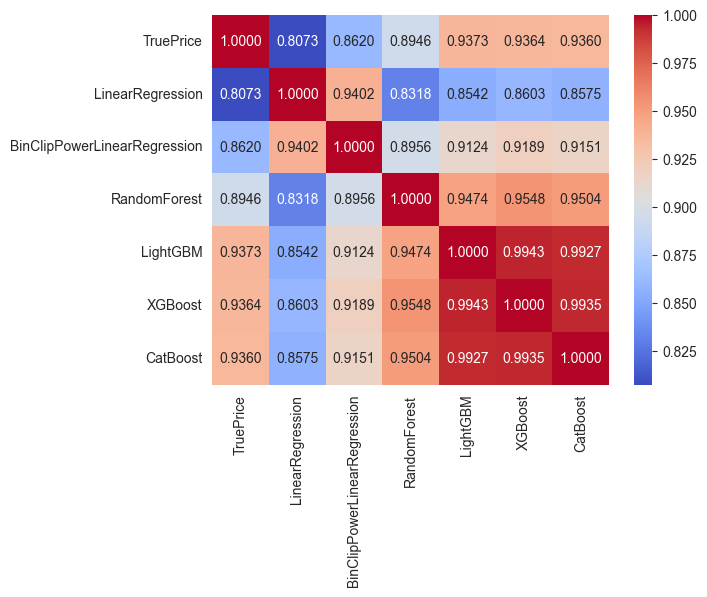

In [139]:
sns.heatmap(predictions.corr(),
            cmap='coolwarm',
            annot=True,
            fmt='.4f');

* Видно, что от остальных моделей сильнее всего отличается линейная регрессия. Это потому, что она в области винтажных машин она уловила неверный тренд. BinClipPowerLinearRegression в этом отношении ближе к деревянным моделям, включая бустинги.
* На основании построенных моделей за исключением линейной регрессии можно было бы построить ансамбль, но оставим это будущим поколениям.

Посмотрим на удельные ошибки предсказаний

In [140]:
errors = x_test.merge(predictions.apply(lambda x: (x.iloc[1:]-x['TruePrice'])/x['TruePrice'], axis=1),
                      left_index=True,
                      right_index=True).merge(y_test, left_index=True, right_index=True)

In [141]:
full_info(errors.iloc[:, -7:])

Feature,Non-Null Count,Null Count,Dtype,count,mean,std,min,25%,50%,75%,max
LinearRegression,65695,0,float64,65695.0,0.369292,1.776882,-18.539977,-0.263567,0.054760,0.592484,54.341913
BinClipPowerLinearRegression,65695,0,float64,65695.0,0.297281,1.450596,-0.968804,-0.236498,-0.012661,0.356950,56.142857
RandomForest,65695,0,float64,65695.0,0.339582,1.060455,-0.936676,-0.164877,0.079656,0.504651,43.014132
LightGBM,65695,0,float64,65695.0,0.184673,0.828156,-4.381616,-0.139350,0.026069,0.281993,46.216100
XGBoost,65695,0,float64,65695.0,0.194059,0.847389,-2.538797,-0.140645,0.029938,0.296199,47.840239
CatBoost,65695,0,float64,65695.0,0.191406,0.861264,-10.523093,-0.142468,0.028818,0.292599,50.953338
price,65695,0,int64,65695.0,4753.163894,4512.748557,309.000000,1350.000000,3000.000000,6800.000000,20000.000000


* Судя по значениям <-1, даже бустинги все-таки предсказывали отрицательную цену. Делаем вывод, что по-хорошему нужно мало даже все бустинги обернуть в класс, прижимающий значения к искомому диапазону.
* Важно посмотреть на минимальные и максимальные ошибки. Например, то, что линейная регрессия предлагает продавцу доплатить за продажу в 18 раз больше, чем тот хочет заработать, не удивляет. Скорее всего, это очень старая машина. Но вот настораживают объявления, где даже бустинги ошиблись примерно в 50 раз. Выведем такие, отсортировав ошибку по любому из бустингов.

In [142]:
errors.sort_values('XGBoost', ascending=False).head(5)

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired,vintage,registration_month_bool,LinearRegression,BinClipPowerLinearRegression,RandomForest,LightGBM,XGBoost,CatBoost,price
65095,convertible,2012.0,manual,170.0,audi a5,50000,petrol,audi,False,False,True,45.547493,49.000000,38.502684,46.216100,47.840239,49.347622,400
94480,suv,2015.0,manual,140.0,volkswagen amarok,30000,gasoline,volkswagen,False,False,True,48.590565,51.083333,40.148629,45.222820,45.870783,35.094838,384
291013,sedan,2012.0,auto,140.0,volkswagen cc,125000,gasoline,volkswagen,False,False,True,33.575922,34.842989,36.356209,42.371867,40.766971,41.066630,418
250772,sedan,NaN,manual,408.0,bmw 5er,50000,gasoline,bmw,True,False,False,38.853846,39.610148,27.912682,37.002528,37.717393,50.953338,400
167013,wagon,2014.0,auto,173.0,renault laguna,30000,gasoline,renault,False,False,True,33.425419,35.338482,42.891871,36.930644,33.191523,48.794276,360


Подобные объявления касаются практически новых автомобилей с ценой в несколько сотен евро, что подозрительно. Впрочем, большинство из ремонта, и неизвестно, насколько серьезное ДТП приключилось с авто, поэтому сервису по продаже было бы полезно ввести признаки, уточняющие серьезность повреждений. Кстати говоря, этот кластер машин с низкой стоимостью был виден на скаттерплоте.

# Вывод

* Рассмотрены 6 моделей машинного обучения, на тестовой выборке сразу тремя моделями достигнута метрика около 1600 евро.
* Быстрее всего учится модель линейной регрессии, но высокую скорость обучения сводит на нет качество предсказаний. В остальном все относительно. Из бустингов быстрее всех учится LightGBM, но скорость обучения бустингов достигается выделением кластера GPU, поэтому вне учебного проекта модель учится однажды и на комфорт пользователя это особо не влияет. Самое быстрое время инференса показал, как ни странно, Catboost
* Наиболее важными признаками оказались год регистрации(выпуска автомобиля), наличие ремонта, пробег и мощность двигателя
* Обнаружен кластер подозрительно дешевых машин. Возможно его стоит выделить в отдельный кластер и добавить это в виде признака в датасет
* Дальнейшее улучшение результата возможно после обсуждения с заказчиком адекватных границ стоимости авто, а также уточнения существующих и добавления новых признаков.
* Также есть смысл рассмотреть для XGBoost иные трансформеры, например, OrdinalEncoder и TargetEncoder